# <center> Вероятность получения грантов/госконтрактов у НКО

## Постановка задачи

В нашем распоряжении есть дамп данных обо всех некоммерческих организациях (далее - НКО) России, в котором содержится информация о получении государственных грантов, госконтрактов и субсидий, регионе и дате регистрации, а также ОКВЭД (классификатор экономической деятельности).

**Задача** — проверить, есть ли зависимость вероятности получения грантов от государства/госконтрактов: 

* от региона регистрации организации; 
* от возраста организации; 
* от экономической деятельности организации. 

**Техническая задача для специалиста в Data Science:** построить модель бинарной классификации НКО на основе их признаков, позволяющей определить получит ли организация финансирование или нет

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках НКО.
4. Построить несколько моделей машинного обучения, решающих задачу классификации клиентов.
5. Спроектировать процесс предсказания класса НКО и протестировать вашу модель на новых НКО.


*Источник данных* — [проект «Открытые НКО»](https://openngo.ru/). 

[Дамп данных в формате JSON](https://drive.google.com/file/d/1PQweRjt7uX00mWva0_goaj8JLz1tiTLx/view?usp=sharing) (актуален на 26.08.2021). 

[Описание полей на GitHub](https://github.com/infoculture/openngo-data-reference/wiki/Характеристики-и-расшифровки-открытых-данных)

*UPD:* [foundations_codes.csv](https://github.com/Teplitsa/CSRLab/blob/main/Skillfactory%20x%20Teplitsa%20Lab/foundations_codes.csv) — таблица с более точными кодами правовой формы (ОКОПФ) для фондов всех видов.

## Данные и их описание

Данные представляют собой архив, в котором несколько файлов в формате JSON, в каждой строке которой содержится информация об отдельной НКО.

Примеры признаков, описывающие каждую НКО:

* addOkved: дополнительный ОКВЭД;
* address: юридический адрес;
* administrators: руководители организации;
* dateOgrn: дата присвоения ОГРН - начиная с 2002 года;
* dateReg: дата регистрации организаций - указывается только для организаций, зарегистрированных до 2002 года;
* incomeDetail: детализация сведений о доходах;
* incomeDetail.contracts223: сведения о доходах от контрактации по 223-ФЗ
* incomeDetail.fedSubsidies: сведения о соглашениях о предоставлении федеральных субсидий;
* incomeDetail.grants: сведения о полученных президентских грантах
* incomeRank: уровень дохода
* incomeTotal: общая сумма доходов из известных источников - контрактов, договоров, президентских грантов, федеральных субсидий
* okfs.code: код ОКФС
И т.д.


Всего 97 признаков. 

[Полное описание полей на GitHub](https://github.com/infoculture/openngo-data-reference/wiki/Характеристики-и-расшифровки-открытых-данных)

Импорт библиотек:

In [1]:
# открытие файлов
import json
from zipfile import ZipFile
import time


# базовые библиотеки
import pandas as pd
import numpy as np


# статисследования и кодирование 
from scipy.stats import chi2_contingency
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder


# визуализация
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')


# отбор признаков, оптимизация параметров
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from imblearn.over_sampling import SMOTE
import optuna


# модели и метрики
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from sklearn import metrics


# пайплайн и продакшен
from sklearn.pipeline import Pipeline
import joblib
import pickle
from sklearn.base import TransformerMixin, BaseEstimator

In [3]:
!pip freeze > requirements.txt

In [108]:
# # Для начала прочитаем все файлы в архиве и объединим их в отдельный DataFrame
# # Предупреждение: чтение архива и формирование df может занимать около 9 минут
# # поэтому код закоментирован, при необходимости комментирование можно убрать

# archive = 'data/data.zip'
# zip_file = ZipFile(archive)

# # пустой df для объединения      
# df_output = pd.DataFrame()           

# # временная отметка о начале операции чтения и объединения
# localtime_start = time.time()


# # читаем архив, читаем построчно json файлы, нормализуем, добавляем в итоговый df  
# for text_file in zip_file.infolist():
#     if text_file.filename.endswith('.json'):
        
#         json_data = [json.loads(line) for line in zip_file.open(text_file.filename)]
#         df_normalized = pd.json_normalize(json_data)
        
#         print(f'{text_file.filename} - прочитан, размерность - {df_normalized.shape}, время от старта чтения архива - {round(time.time() - localtime_start)} cек')
#         df_output = pd.concat([df_output, df_normalized])
        
        
# # openngo_2021_26_08/ngo_dump_01.json - прочитан, размерность - (50000, 148), время от старта чтения архива - 28 cек
# # openngo_2021_26_08/ngo_dump_05.json - прочитан, размерность - (50000, 144), время от старта чтения архива - 68 cек
# # openngo_2021_26_08/ngo_dump_09.json - прочитан, размерность - (50000, 146), время от старта чтения архива - 99 cек
# # openngo_2021_26_08/ngo_dump_08.json - прочитан, размерность - (50000, 164), время от старта чтения архива - 128 cек
# # openngo_2021_26_08/ngo_dump_02.json - прочитан, размерность - (50000, 150), время от старта чтения архива - 171 cек
# # openngo_2021_26_08/ngo_dump_04.json - прочитан, размерность - (50000, 164), время от старта чтения архива - 205 cек
# # openngo_2021_26_08/ngo_dump_14.json - прочитан, размерность - (50000, 112), время от старта чтения архива - 240 cек
# # openngo_2021_26_08/ngo_dump_12.json - прочитан, размерность - (50000, 126), время от старта чтения архива - 281 cек
# # openngo_2021_26_08/ngo_dump_10.json - прочитан, размерность - (50000, 160), время от старта чтения архива - 329 cек
# # openngo_2021_26_08/ngo_dump_13.json - прочитан, размерность - (50000, 154), время от старта чтения архива - 367 cек
# # openngo_2021_26_08/ngo_dump_07.json - прочитан, размерность - (50000, 132), время от старта чтения архива - 396 cек
# # openngo_2021_26_08/ngo_dump_03.json - прочитан, размерность - (50000, 138), время от старта чтения архива - 425 cек
# # openngo_2021_26_08/ngo_dump_06.json - прочитан, размерность - (50000, 100), время от старта чтения архива - 454 cек
# # openngo_2021_26_08/ngo_dump_15.json - прочитан, размерность - (50000, 148), время от старта чтения архива - 496 cек
# # openngo_2021_26_08/ngo_dump_11.json - прочитан, размерность - (47034, 162), время от старта чтения архива - 531 cек

In [109]:
# # Сформированный файл сохраняем в архив, чтобы потом к нему обращаться (вместо чтения первоначального архива)
# # Предупреждение: создание и архивирование файла может занимать около 7 минут


# # временная отметка о начале операции архивирования
# localtime_start = time.time()

# compression_opts = dict(method='zip', archive_name='output.csv') 
# # Определяем параметры архивирования — метод сжатия, имя файла в архиве

# df_output.to_csv('data/output.zip', index=False, compression=compression_opts)
# #В ходе выполнения кода содержимое DataFrame сохранено в файле output.csv, 
# # файл упакован в архив output.zip, а архив записан в каталог data.

# print(f'Время выполнения записи в архив - {round(time.time() - localtime_start)} cек')

# # Время выполнения записи в архив - 409 cек

In [24]:
# Подтягиваем данные из сохранённого файла
# Предупреждение: загрузка данных из файла может занимать около 2 минут
data = pd.read_csv('data/output.zip')

C:\Users\пользователь\AppData\Local\Temp\ipykernel_7532\2164484383.py:3: DtypeWarning: Columns (0,12,16,23,33,49,51,53,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/output.zip')


In [25]:
data.shape
# (747034, 198)

(747034, 198)

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомимся с исходными данными поближе:

* Уберём из списка недействующие организации
* Объединим некоторые признаки
* Удалим признаки со слабой информацией, дублирующие признаки 
* Проведем статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Переведём столбцы в корректные форматы (например, даты в формат datetime).
* Исследуем данные на наличие пропусков и дубликатов.

In [26]:
data_prepared = data.copy()

In [27]:
data_prepared.head()

,minjustRegNum,regionName,logo,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,egrulStatus,...,incomeDetail.fedSubsidies.2011.sum,incomeDetail.fedSubsidies.2011.count,incomeDetail.contracts223.2004.sum,incomeDetail.contracts223.2004.count,incomeDetail.fedSubsidies.2007.sum,incomeDetail.fedSubsidies.2007.count,incomeDetail.fedSubsidies.2006.sum,incomeDetail.fedSubsidies.2006.count,incomeDetail.fedSubsidies.2005.sum,incomeDetail.fedSubsidies.2005.count
0,7814061218.0,Санкт-Петербург,NaN,МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,NaN,"Объединения (союз, ассоциация) юридических лиц",NaN,Зарегистрирована,1207800141790,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7714017452.0,Москва,NaN,"ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",NaN,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7814170160.0,Санкт-Петербург,NaN,"КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",NaN,Коллегия адвокатов,NaN,Зарегистрирована,1207800011430,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Москва,NaN,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",NaN,NaN,NaN,NaN,1207700348976,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7814052913.0,Санкт-Петербург,NaN,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",NaN,Автономная некоммерческая организация,NaN,Зарегистрирована,1207800081500,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1. Убираем из данных недействующие организации

In [28]:
# В исходных данных есть недействующие организации
data_prepared['egrulStatus'].value_counts(normalize=True)
# Их порядка 54%

Ликвидирована    0.543662
Действует        0.456338
Name: egrulStatus, dtype: float64

In [29]:
# Избавимся от них
# т.к. в рамках предсказания для НКО для получения финансирования и участия в конкурсах ожидается, что она будет действующей, а не ликвидированной.

# Здесь и далее в проекте преобразованный df после каждой фазы сохраняю с другим окончанием (например, _11, _12)
data_prepared_11 = data_prepared[data_prepared['egrulStatus']=='Действует']
data_prepared_11.shape[0]

#Количество записей о юрлицах уменьшилось до 340 тыс. 

340900

### 1.2 Работа с полностью пустыми столбцами

In [30]:
# Исходное количество признаков очень большое. Их так много, что они даже их краткое описание выводится с трудом

# В исходных данных много лишних столбцов, которые можно объединить в один
# Также есть столбцы с полностью пустыми значениями

# Сформируем df c долей пустных значений

cols_null_percent = data_prepared_11.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent==100].sort_values(ascending=False)
display(cols_with_null)

# Это столбцы с лого, ссылкой на устав, датой регистрации (если зарегистрировано до 2022 года) и датой ликвидации, а также некоторые столбцы результатами по контрактам за некоторые года

logo                                   100.0
dateReg                                100.0
charter                                100.0
dateLiquid                             100.0
dateLiquid.$date                       100.0
incomeDetail.contracts94.2006.sum      100.0
incomeDetail.contracts94.2006.count    100.0
incomeDetail.contracts44.2002.sum      100.0
incomeDetail.contracts44.2002.count    100.0
dtype: float64

In [31]:
# Уберём указанные столбцы
data_prepared_12 = data_prepared_11.drop(list(cols_with_null.index), axis=1)

In [32]:
data_prepared_12.shape
# Размерность уменьшилась до (340900, 189)

(340900, 189)

### 1.3 Объединение признаков и удаление лишних

In [33]:
# Теперь посмотрим сколько организаций вообще получило финансирование
data_prepared_12[data_prepared_12['incomeTotal']!=0].shape[0]

# 29404, т.е. около 8,6% от общего количества оставщегося датасета

# Т.к. классификация у нас будет бинарная, то сделаем сигнальный признак
data_prepared_13 = data_prepared_12.copy()
data_prepared_13['incomeTotal_signal'] = data_prepared_13['incomeTotal'].apply(lambda x: 1 if x!=0 else 0)

In [34]:
# Для целей задачи данные из полей contracts44, contracts223, contracts94 можно суммировать (это разные формы контрактов, но это имеет значение только для заказчика).
# поэтому используем объединим значения в этих столбцах в одно, что позволит сразу уменьшить количество столбцов

for i in range(2000, 2020):
    for j in ['sum','count','totalSum', 'totalCount']:
        
        if f'incomeDetail.contracts223.{i}.{j}' in data_prepared_13.columns:
            contract223 = data_prepared_13[f'incomeDetail.contracts223.{i}.{j}']
            data_prepared_13 = data_prepared_13.drop([f'incomeDetail.contracts223.{i}.{j}'], axis=1)
        else: contract223 = 0
        
        
        if f'incomeDetail.contracts44.{i}.{j}' in data_prepared_13.columns:
            contract44 = data_prepared_13[f'incomeDetail.contracts44.{i}.{j}']
            data_prepared_13 = data_prepared_13.drop([f'incomeDetail.contracts44.{i}.{j}'], axis=1)
        else: contract44 = 0
            
            
        if f'incomeDetail.contracts94.{i}.{j}' in data_prepared_13.columns:
            contract94 = data_prepared_13[f'incomeDetail.contracts94.{i}.{j}']
            data_prepared_13 = data_prepared_13.drop([f'incomeDetail.contracts94.{i}.{j}'], axis=1)
        else: contract94 = 0   
            
            
        data_prepared_13[f'incomeDetail.allcontracts.{i}.{j}'] = contract223 + contract44 + contract94
        
        # удаляем пустые столбцы, которые получились
        if data_prepared_13[f'incomeDetail.allcontracts.{i}.{j}'].sum()==0:
            data_prepared_13 = data_prepared_13.drop([f'incomeDetail.allcontracts.{i}.{j}'], axis=1) 

In [35]:
len(data_prepared_13.columns)
# Количество признаков уменьшилось до 134

134

### 1.4 Удаление признаков со слабой информацией, удаление дубликатов

In [36]:
data_prepared_14 = data_prepared_13.copy()

In [37]:
# Также нас не будут интересовать 100% уникальные значения признаков, например название название учетной записи в vk скорее всего будет уникальным). 

#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data_prepared_14.columns:
    #наибольшая относительная частота в признаке
    top_freq = data_prepared_14[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data_prepared_14[col].nunique() / data_prepared_14[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 4)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 4)}% уникальных значений')


minjustRegNum: 99.9703% уникальных значений
ogrn: 100.0% уникальных значений
egrulStatus: 100.0% одинаковых значений
email: 96.5495% уникальных значений
administrators: 95.4605% уникальных значений
inn: 100.0% уникальных значений
okpo: 100.0% уникальных значений
website: 100.0% уникальных значений
successors: 99.8615% одинаковых значений
hasRegionalSupport: 97.1179% одинаковых значений
website_punycode: 100.0% уникальных значений
predecessors: 97.7665% одинаковых значений
statusDetail.shortName: 97.269% одинаковых значений
opf.version: 99.9918% одинаковых значений
mainOkved.version: 96.6885% одинаковых значений
incomeDetail.grants.totalCount: 96.8281% одинаковых значений
incomeDetail.grants.totalSum: 96.8281% одинаковых значений
incomeDetail.fedSubsidies.totalCount: 99.1954% одинаковых значений
incomeDetail.fedSubsidies.totalSum: 99.1998% одинаковых значений
incomeDetail.contracts44.totalCount: 95.9783% одинаковых значений
incomeDetail.contracts44.totalSum: 95.9795% одинаковых значений

In [38]:
#Столбцов с низким уровнем информативности - 89
len(low_information_cols)

89

In [39]:
# Столбцов с уникальными и одинаковыми значениями получилось достаточно много
# Возможно есть дубликаты?

dupl_columns = list(data_prepared_14.columns)
mask = data_prepared_14.duplicated(subset=dupl_columns)
df_duplicates = data_prepared_14[mask]
print(f'Число найденных дубликатов: {df_duplicates.shape[0]}')

# полных дубликатов нет

Число найденных дубликатов: 0


In [40]:
# Теперь для того, чтобы принять решение об исключении будем сравнивать значения в столбцах по всему датасету и по выборке организаций, получивших финансирование
# Если цифры совпадут, то столбец будем удалять


# выборка НКО, где получено финансирование
sample = data_prepared_14[data_prepared['incomeTotal']!=0]

#создаем df для заполнения
top_freq_data_columns = pd.DataFrame(columns = ['all_data', 'sample'], index = low_information_cols)


# заполняем df расчётными значениями признаков
for col in data_prepared_14.columns:
    top_freq_all_data = data_prepared_14[col].value_counts(normalize=True).max()
    top_freq_sample = sample[col].value_counts(normalize=True).max()
    
    if top_freq_all_data > 0.95:
        top_freq_data_columns['all_data'][col] = round(top_freq_all_data*100, 4)
    if top_freq_sample > 0.95:
        top_freq_data_columns['sample'][col] = round(top_freq_sample*100, 4)
        
#выводим таблицу с признакам, где показатели одинаковые
top_freq_data_columns[top_freq_data_columns['all_data']==top_freq_data_columns['sample']]

top_freq_data_columns[top_freq_data_columns['all_data']==top_freq_data_columns['sample']].shape[0]
#получилось 46 признаков

C:\Users\пользователь\AppData\Local\Temp\ipykernel_7532\2159386324.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data_prepared_14[data_prepared['incomeTotal']!=0]


46

In [41]:
# удаляем лишние столбцы
to_drop_list =  list(top_freq_data_columns[top_freq_data_columns['all_data']==top_freq_data_columns['sample']].index)
 
data_prepared_14 = data_prepared_14.drop(to_drop_list, axis=1)

In [42]:
len(data_prepared_14.columns)
# Уменьшили до 109 признаков

109

In [43]:
# теперь прогоним по уникальным значениям

sample = data_prepared_14[data_prepared['incomeTotal']!=0]

#создаем df для заполнения
nunique_data_columns = pd.DataFrame(columns = ['all_data', 'sample'], index = low_information_cols)


# заполняем df расчётными значениями признаков
for col in data_prepared_14.columns:
    nunique_all_data = data_prepared_14[col].nunique() / data_prepared_14[col].count()
    nunique_sample = sample[col].nunique() / sample[col].count()
    
    if nunique_all_data > 0.95:
        nunique_data_columns['all_data'][col] = round(nunique_all_data*100, 4)
        
    if nunique_sample > 0.95:
        nunique_data_columns['sample'][col] = round(nunique_sample*100, 4)
        
#выводим таблицу с признакам, где показатели одинаковые
nunique_data_columns[nunique_data_columns['all_data']==nunique_data_columns['sample']]

nunique_data_columns[nunique_data_columns['all_data']==nunique_data_columns['sample']].shape[0]
#получилось 24 признака

C:\Users\пользователь\AppData\Local\Temp\ipykernel_7532\112319453.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = data_prepared_14[data_prepared['incomeTotal']!=0]


24

In [44]:
# удалим указанные признаки, оставив при этом признак orgn - по нему будем идентифицировать организацию

to_drop_list2 = list(nunique_data_columns[nunique_data_columns['all_data']==nunique_data_columns['sample']].index)
to_drop_list2.remove('ogrn')
data_prepared_14 = data_prepared_14.drop(to_drop_list2, axis=1)

In [45]:
data_prepared_14.shape[1]
# Уменьшили до 86 признаков

86

### 1.5 Удаление признаков, которые косвенно дублируют информацию

In [132]:
data_prepared_15 = data_prepared_14.copy()

In [133]:
# Далее уберем все столбцы IncomeDetail (кроме incomeTotal_signal), т.к. они уже говорят о том, что финансирование было получено и будут давать высокую корреляцию с итоговым признаком
# косвенно это будет утечкой данных

for i in data_prepared_15.columns:
    if i.split('.')[0]=='incomeDetail':
        data_prepared_15 = data_prepared_15.drop([i], axis=1)

In [134]:
len(data_prepared_15.columns)
# Уменьшили количество признаков до 39

39

Теперь будем удалять оставшиеся столбцы точечно (ручным поиском) исходя из той информации, которую они отражают:

* `minjustRegNum` - уникальный идентификатор организации, поэтому не внесет вклад в предсказание
* `regionCode` - код региона организации, дублирует `regionName`, поэтому тоже не нужен
* `address` - уже есть код региона и код ОКАТО, адрес слишком уникальный
* `fullName` - полное наименование организации, уникально, поэтому не внесет вклад в предсказание
* `administrators` - руководитель, уникально, поэтому не внесет вклад в предсказание
* `successors` - почти пустой
* `shortName` - уникальный идентификатор организации, поэтому не внесет вклад в предсказание
* `predecessors` - почти пустой
* `reports` - отчеты, передаваемые в минюст и ссылки на них
* `statusDetail.name` - дает расшифровку почему организация не имеет тип "действующая"
* `statusDetail.code` - дает расшифровку почему организация не имеет тип "действующая"
* `opf.code` - расшифровка для поля `opf.name`
* `opf.version` - версия справочника ОПФ, почти у всех одинаковая
* `oktmo.code` - расшифровка для поля `oktmo.name`
* `mainOkved.code` - расшифровка для поля `mainOkved.name`
* `mainOkved.version` - версия справочника ОКВЭД, почти у всех одинаковая
* `okogu.code` - расшифровка для поля `okogu.name`
* `okato.code` - расшифровка для поля `okato.name`
* `okfs.code` - расшифровка для поля `okfs.name`

Признак `incomeTotal` тоже удалим, т.к. нам не важно какой объем финансирования получит НКО, главное - получит или нет. 

In [135]:
# Удаляем указанные столбцы
to_drop_list3 = [
    'minjustRegNum','regionCode', 'address', 'fullName', 'administrators', 
    'successors', 'shortName', 'predecessors', 'reports', 'statusDetail.name', 
    'statusDetail.code','opf.code', 'opf.version','oktmo.code', 'mainOkved.code',
    'mainOkved.version','okogu.code','okato.code','okfs.code','incomeTotal']
data_prepared_15 = data_prepared_15.drop(to_drop_list3, axis=1)

In [136]:
# Осталось 19 признаков, в т.ч. сигнальный 
# С ними и будем работать
data_prepared_15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340900 entries, 0 to 747033
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   regionName              340899 non-null  object 
 1   minjustForm             234777 non-null  object 
 2   minjustStatus           235982 non-null  object 
 3   ogrn                    340900 non-null  int64  
 4   email                   7593 non-null    object 
 5   kpp                     340800 non-null  float64
 6   hasRegionalSupport      340900 non-null  bool   
 7   addOkved                340900 non-null  object 
 8   statusDetail.shortName  340900 non-null  object 
 9   opf.name                340896 non-null  object 
 10  oktmo.name              253422 non-null  object 
 11  mainOkved.name          329702 non-null  object 
 12  originDate.$date        340900 non-null  object 
 13  okogu.name              318138 non-null  object 
 14  okato.name          

### 1.6 Работа с пропусками, перевод даты и доп ОКВЭД в корректный формат

In [137]:
data_prepared_16 = data_prepared_15.copy()

In [138]:
# В данных есть пропуски
data_prepared_16.isnull().mean()

regionName                0.000003
minjustForm               0.311302
minjustStatus             0.307768
ogrn                      0.000000
email                     0.977727
kpp                       0.000293
hasRegionalSupport        0.000000
addOkved                  0.000000
statusDetail.shortName    0.000000
opf.name                  0.000012
oktmo.name                0.256609
mainOkved.name            0.032848
originDate.$date          0.000000
okogu.name                0.066770
okato.name                0.091018
okfs.name                 0.066741
dateOgrn.$date            0.000000
dateReg.$date             0.659229
incomeTotal_signal        0.000000
dtype: float64

In [139]:
# Посмотрим много ли мы потеряем в данных с отметкой о получении финансирования, если откажемся от объектов с пропусками, удалив их
data_prepared_16[data_prepared_16['incomeTotal_signal']==1].isnull().mean()
# Получается прилично, удалять не рекомендуется

regionName                0.000000
minjustForm               0.142566
minjustStatus             0.113216
ogrn                      0.000000
email                     0.989389
kpp                       0.000000
hasRegionalSupport        0.000000
addOkved                  0.000000
statusDetail.shortName    0.000000
opf.name                  0.000000
oktmo.name                0.281458
mainOkved.name            0.017243
originDate.$date          0.000000
okogu.name                0.004999
okato.name                0.016970
okfs.name                 0.004727
dateOgrn.$date            0.000000
dateReg.$date             0.723235
incomeTotal_signal        0.000000
dtype: float64

In [140]:
# Будем заполнять пропуски по словарю

#создаем словарь имя столбца: значение, на на которое надо заменить пропуски
# буду ставить на фиксированное значение, т.к. количество значений в каждом признаке велико
values = {
    'regionName': 'Не определено',
    'minjustForm': 'Не указано',
    'minjustStatus': 'Не указано',
    'email': 'Не указано',
    'kpp':'Не указано',
    'opf.name': 'Не указано',
    'oktmo.name': 'Не указано',
    'mainOkved.name': 'Не указано',
    'okogu.name': 'Не указано',
    'okato.name': 'Не указано',
    'okfs.name':'Не указано'
}

#заполняем пропуски в соответствии с заявленным словарем
data_prepared_16 = data_prepared_16.fillna(values)

#данные с пустым признаком kpp удалю - их немного, в данных с отметкой о получении финансирования пустых вообще нет
data_prepared_16 = data_prepared_16[data_prepared_16['kpp']!='Не указано']
# Количество строк уменьшится на 100 (с 340900 до 340800)

#выводим результирующую долю пропусков
data_prepared_16.isnull().mean()

regionName                0.000000
minjustForm               0.000000
minjustStatus             0.000000
ogrn                      0.000000
email                     0.000000
kpp                       0.000000
hasRegionalSupport        0.000000
addOkved                  0.000000
statusDetail.shortName    0.000000
opf.name                  0.000000
oktmo.name                0.000000
mainOkved.name            0.000000
originDate.$date          0.000000
okogu.name                0.000000
okato.name                0.000000
okfs.name                 0.000000
dateOgrn.$date            0.000000
dateReg.$date             0.659302
incomeTotal_signal        0.000000
dtype: float64

In [141]:
# Пробуем перекодировать даты и вытащить год
for i in ['dateOgrn.$date','dateReg.$date','originDate.$date']:
    data_prepared_16[i] = pd.to_datetime(data_prepared_16[i])
    data_prepared_16[f'{i.split(".")[0]}.year'] = data_prepared_16[i].dt.year


In [142]:
#Проверим совпадают ли дата признаки originDate.year и dateReg.year

data_prepared_16['check.year'] = data_prepared_16['originDate.year'] - data_prepared_16['dateReg.year']
data_prepared_16['check.year'].value_counts()

# Да, совпадают, поэтому лишние столбцы можно удалить

0.0    116110
Name: check.year, dtype: int64

In [143]:
#ненужные столбцы удаляем 
data_prepared_16 = data_prepared_16.drop(['originDate.$date', 'dateOgrn.$date','dateReg.$date','dateReg.year','check.year'], axis=1)

In [144]:
# из столбца addOkved вытащим данные
data_prepared_16['addOkved'][1]

# они записаны в формате json

"[{'name': 'Издание книг', 'code': '58.11', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}, {'name': 'Издание газет', 'code': '58.13', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}, {'name': 'Виды издательской деятельности прочие', 'code': '58.19', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}, {'name': 'Издание аудиовизуальных произведений на магнитных, электронных и цифровых носителях', 'code': '59.20.1', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}]"

In [145]:
# пишем функцию для преобразования
def addokved_codes(value):
    #проверяем на пустые значения
    if value=='[]':
        return value
    
    #заменяем кавычки, чтобы json.loads верно прочитал
    string = value.replace("'",'"')
    
    #читаем
    lst = json.loads(string)
    
    #берём нужны коды и сортируем
    return list(pd.DataFrame(lst)['code'])

In [146]:
localtime_start = time.time()

# Формируем новый признак
data_prepared_16['addOkvedCodes'] = data_prepared_16['addOkved'].apply(lambda x: addokved_codes(x))

# Предупреждение: код выполняется около 2 минут
print(f'Время выполнения операции - {round(time.time() - localtime_start)} cек')

# Время выполнения операции - 143 cек

Время выполнения операции - 156 cек


In [147]:
# сделаем ещё один признак по количеству дополнительных кодов

data_prepared_16['addOkvedCodesCount'] = data_prepared_16['addOkvedCodes'].apply(lambda x: 0 if x=='[]' else len(x))

In [148]:
# Большинство дополнительных кодов отсутствует
data_prepared_16['addOkvedCodesCount'].value_counts(normalize=True).head(5)

#Поэтому будем использовать первые 5 дополнительных кодов, включая пропуск (на них приходится более 80% значений)

0    0.549445
1    0.102424
2    0.077344
3    0.055411
4    0.044894
Name: addOkvedCodesCount, dtype: float64

In [149]:
data_prepared_16['addOkvedCodes']

0                                                       []
1                           [58.11, 58.13, 58.19, 59.20.1]
2                                                       []
3                                           [68.20, 68.10]
4         [73.20, 58.11.1, 93.29.9, 85.41.9, 88.99, 70.21]
                                ...                       
747027                                  [68.32.2, 68.32.1]
747030                                                  []
747031                                           [68.32.2]
747032                                  [68.32.2, 68.20.2]
747033                                  [68.32.2, 68.32.1]
Name: addOkvedCodes, Length: 340800, dtype: object

In [150]:
# выводим первые 4 кода в отдельные столбцы
for i in list(range(4)):
    data_prepared_16[f'addOkvedCodes{i+1}Position'] = data_prepared_16['addOkvedCodes'].apply(lambda x: '0' if x=='[]' or len(x)<i+1 else x[i])

In [151]:
#удаляем два столбца, которые преобразовывали
data_prepared_16 = data_prepared_16.drop(['addOkved','addOkvedCodes'], axis=1)

In [152]:
# Итог всех манипуляций
data_prepared_16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340800 entries, 0 to 747033
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   regionName              340800 non-null  object
 1   minjustForm             340800 non-null  object
 2   minjustStatus           340800 non-null  object
 3   ogrn                    340800 non-null  int64 
 4   email                   340800 non-null  object
 5   kpp                     340800 non-null  object
 6   hasRegionalSupport      340800 non-null  bool  
 7   statusDetail.shortName  340800 non-null  object
 8   opf.name                340800 non-null  object
 9   oktmo.name              340800 non-null  object
 10  mainOkved.name          340800 non-null  object
 11  okogu.name              340800 non-null  object
 12  okato.name              340800 non-null  object
 13  okfs.name               340800 non-null  object
 14  incomeTotal_signal      340800 non-n

In [153]:
# сохраним df в файл, чтобы потом к нему обращаться

# # временная отметка о начале операции архивирования
# localtime_start = time.time()

# compression_opts = dict(method='zip', archive_name='output_reduced.csv') 
# # Определяем параметры архивирования — метод сжатия, имя файла в архиве

# data_prepared_16.to_csv('data/output_reduced.zip', index=False, compression=compression_opts)
# #В ходе выполнения кода содержимое DataFrame сохранено в файле output_reduced.csv, 
# # файл упакован в архив output_reduced.zip, а архив записан в каталог data.

# print(f'Время выполнения записи в архив - {round(time.time() - localtime_start)} cек')

# Время выполнения записи в архив - 29 cек

Время выполнения записи в архив - 29 cек


#### **Вывод:**
От первоначальных данных у нас осталось 340800 объектов с 22 признаками. Результаты достигнуты:
* Отказом от использования данных ликвидированных организаций
* Объединением признаков
* Отказом от дублирующих признаков (name-code)
* Отказом от малоинформативных признаков
* Заменой и удалением пропусков

## 2. EDA + Статистические тесты

После предобработки исходных данных произведём разведывательный анализ и исследуем НКО, ответив на следующие вопросы:

* Есть зависимость получения финансирования от региона регистрации?
* Есть зависимость получения финансирования от возраста организации?
* Есть зависимость получения финансирования от вида экономической деятельности?

Также проверим и другие интересные закономерности

In [2]:
df = pd.read_csv('data/output_reduced.zip')

### 2.1 Есть ли зависимость получения финансирования от региона регистрации ?

Попробуем разобраться: если зависимости нет, то региональная структура НКО, которые получили финансирование, будет соответствовать общей региональной структуре НКО

In [3]:
# Выгрузим распределение НКО по основным городам
# Вычислим частоту для каждого региона, объединим в df, а затем найдём разницу

region0 = pd.DataFrame(df['regionName'].value_counts(normalize=True)*100)
region0.columns = ['incomeTotal_signal']
region0['regionName'] = region0.index


region1 = pd.DataFrame(df[df['incomeTotal_signal']==1]['regionName'].value_counts(normalize=True)*100)
region1.columns = ['incomeTotal_signal']
region1['regionName'] = region1.index


region_result = region0.merge(right=region1, how='left', on='regionName')
region_result['diff'] = region_result['incomeTotal_signal_y'] - region_result['incomeTotal_signal_x']
region_result.sort_values(by=['incomeTotal_signal_y'], ascending=False)

,incomeTotal_signal_x,regionName,incomeTotal_signal_y,diff
0,10.915786,Москва,16.392328,5.476541
2,3.839495,Санкт-Петербург,6.686165,2.846670
1,6.500000,Московская область,2.979187,-3.520813
10,1.987383,Пермский край,2.856754,0.869372
5,2.517312,Республика Татарстан,2.482655,-0.034657
...,...,...,...,...
81,0.145540,Магаданская область,0.170045,0.024505
82,0.112969,Еврейская автономная область,0.119031,0.006062
84,0.058392,Ненецкий автономный округ,0.095225,0.036833
83,0.058685,Чукотский автономный округ,0.064617,0.005932


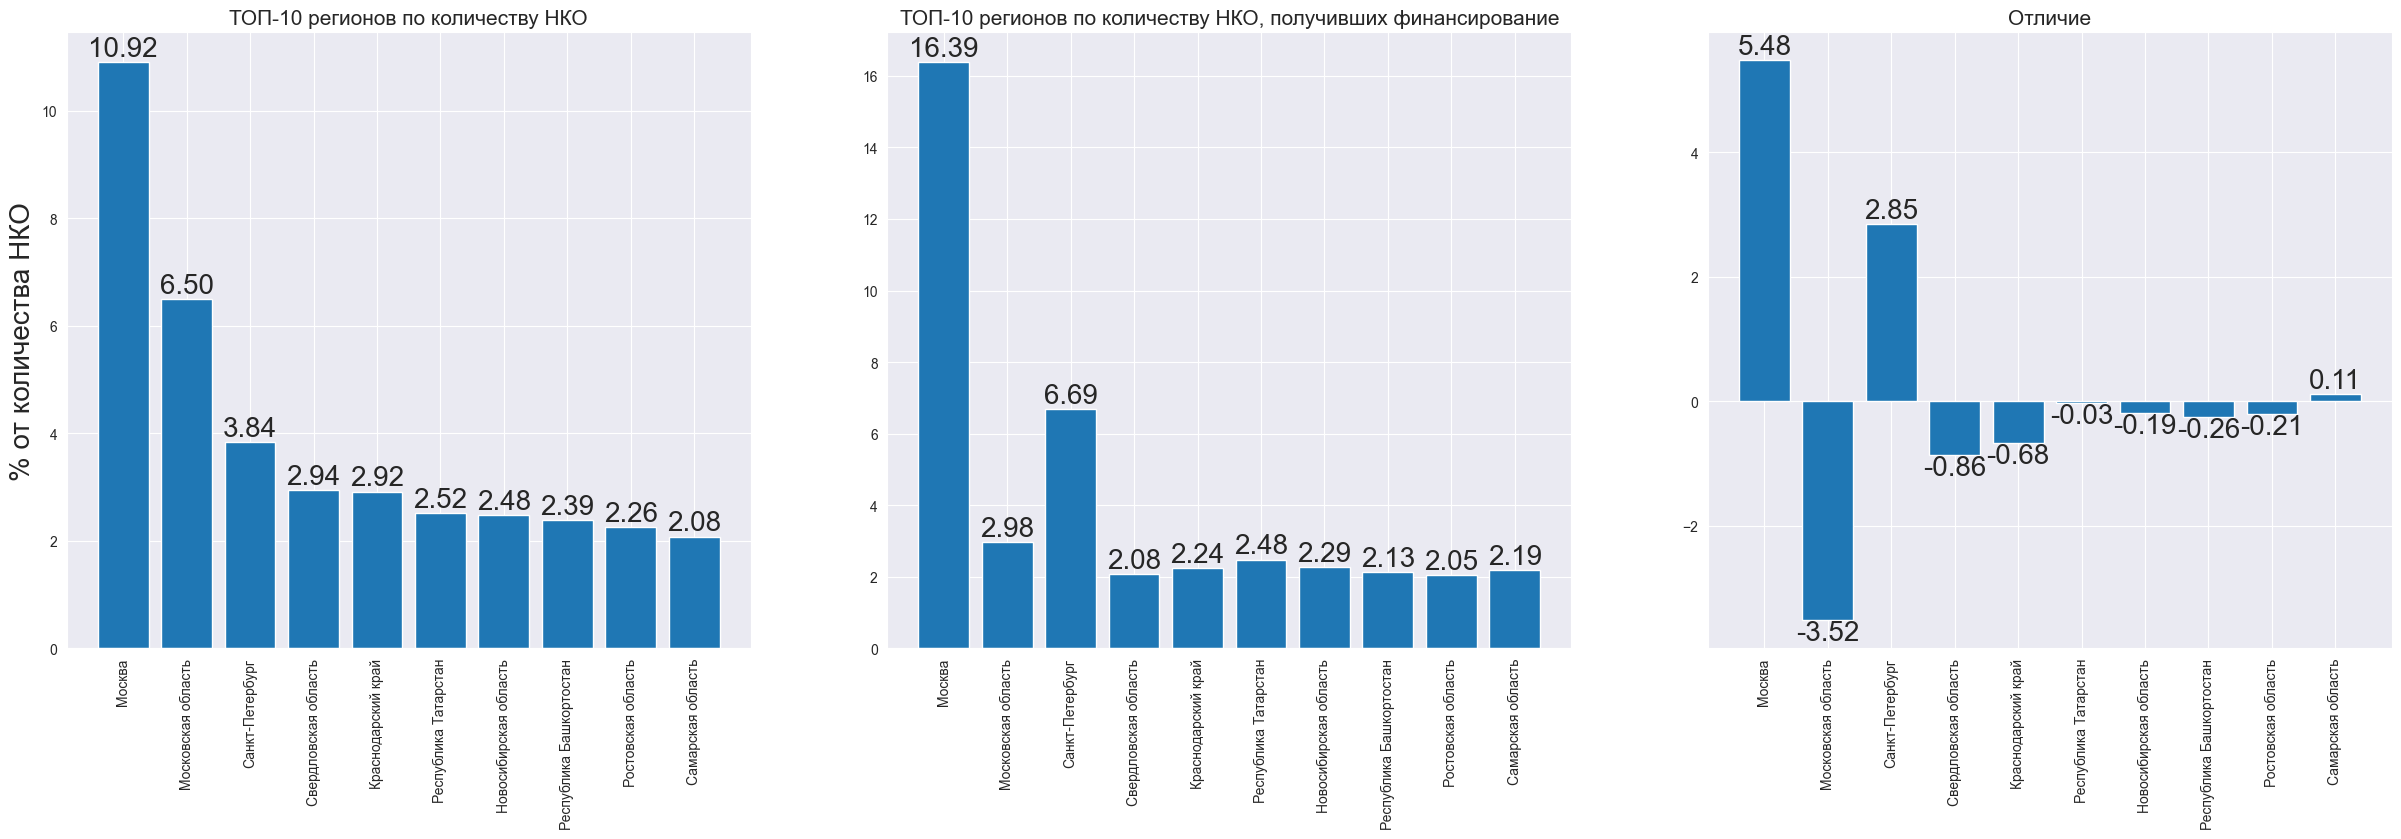

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))

for i, type in enumerate(['incomeTotal_signal_x', 'incomeTotal_signal_y', 'diff']):
    bar1 = axes[i].bar(
        x=region_result['regionName'].head(10).values,
        height=region_result[type].head(10).values
    )
    axes[i].xaxis.set_tick_params(rotation=90)
    axes[i].bar_label(bar1, fmt='%.2f',fontsize=20)
    
axes[0].set_ylabel('% от количества НКО', fontsize=20)
axes[0].set_title("ТОП-10 регионов по количеству НКО", fontsize=15)
axes[1].set_title("ТОП-10 регионов по количеству НКО, получивших финансирование", fontsize=15)
axes[2].set_title("Отличие", fontsize=15)

plt.savefig('data/images/bar_features_regionName.png')

#### Вывод:
На основе представленных данных можно сделать вывод, что есть определённая зависимость от региона регистрации: так при регистрации в Москве и Санкт-Петербурге шансы получить финансирование выше, чем в средние шансы по всем НКО (доля НКО с признаком среди получивших больше, чем в доля НКО с признаком по всем НКО), а при регистрациии в Московской области - ниже.

### 2.2 Есть ли зависимость получения финансирования от возраста организации?

Попробуем разобраться: если зависимости нет, то возрастная структура НКО, которые получили финансирование, будет соответствовать общей возрастной структуре НКО

In [5]:
# Обернём предыдущий блок в функцию:
def bar_features(feature):
    data0 = pd.DataFrame(df[feature].value_counts(normalize=True)*100)
    data0.columns = ['incomeTotal_signal']
    data0[feature] = data0.index


    data1 = pd.DataFrame(df[df['incomeTotal_signal']==1][feature].value_counts(normalize=True)*100)
    data1.columns = ['incomeTotal_signal']
    data1[feature] = data1.index


    data_result = data0.merge(right=data1, how='left', on=feature)
    data_result['diff'] = data_result['incomeTotal_signal_y'] - data_result['incomeTotal_signal_x']
    data_result[feature] = data_result[feature].astype('str')
    data_result = data_result.sort_values(by=['incomeTotal_signal_y'], ascending=False)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))

    for i, type in enumerate(['incomeTotal_signal_x', 'incomeTotal_signal_y', 'diff']):
        bar1 = axes[i].bar(
            x=data_result[feature].head(10).values,
            height=list(data_result[type].head(10).values)
        )
        axes[i].xaxis.set_tick_params(rotation=90)
        axes[i].bar_label(bar1, fmt='%.2f',fontsize=20)
    
    axes[0].set_ylabel('% от количества НКО', fontsize=20)
    axes[0].set_title(f"ТОП-10 значений признака {feature} по количеству НКО", fontsize=15)
    axes[1].set_title(f"ТОП-10 значений признака {feature} количеству НКО, получивших финансирование", fontsize=15)
    axes[2].set_title("Отличие", fontsize=15)
    
    plt.savefig(f'data/images/bar_features_{feature}.png')

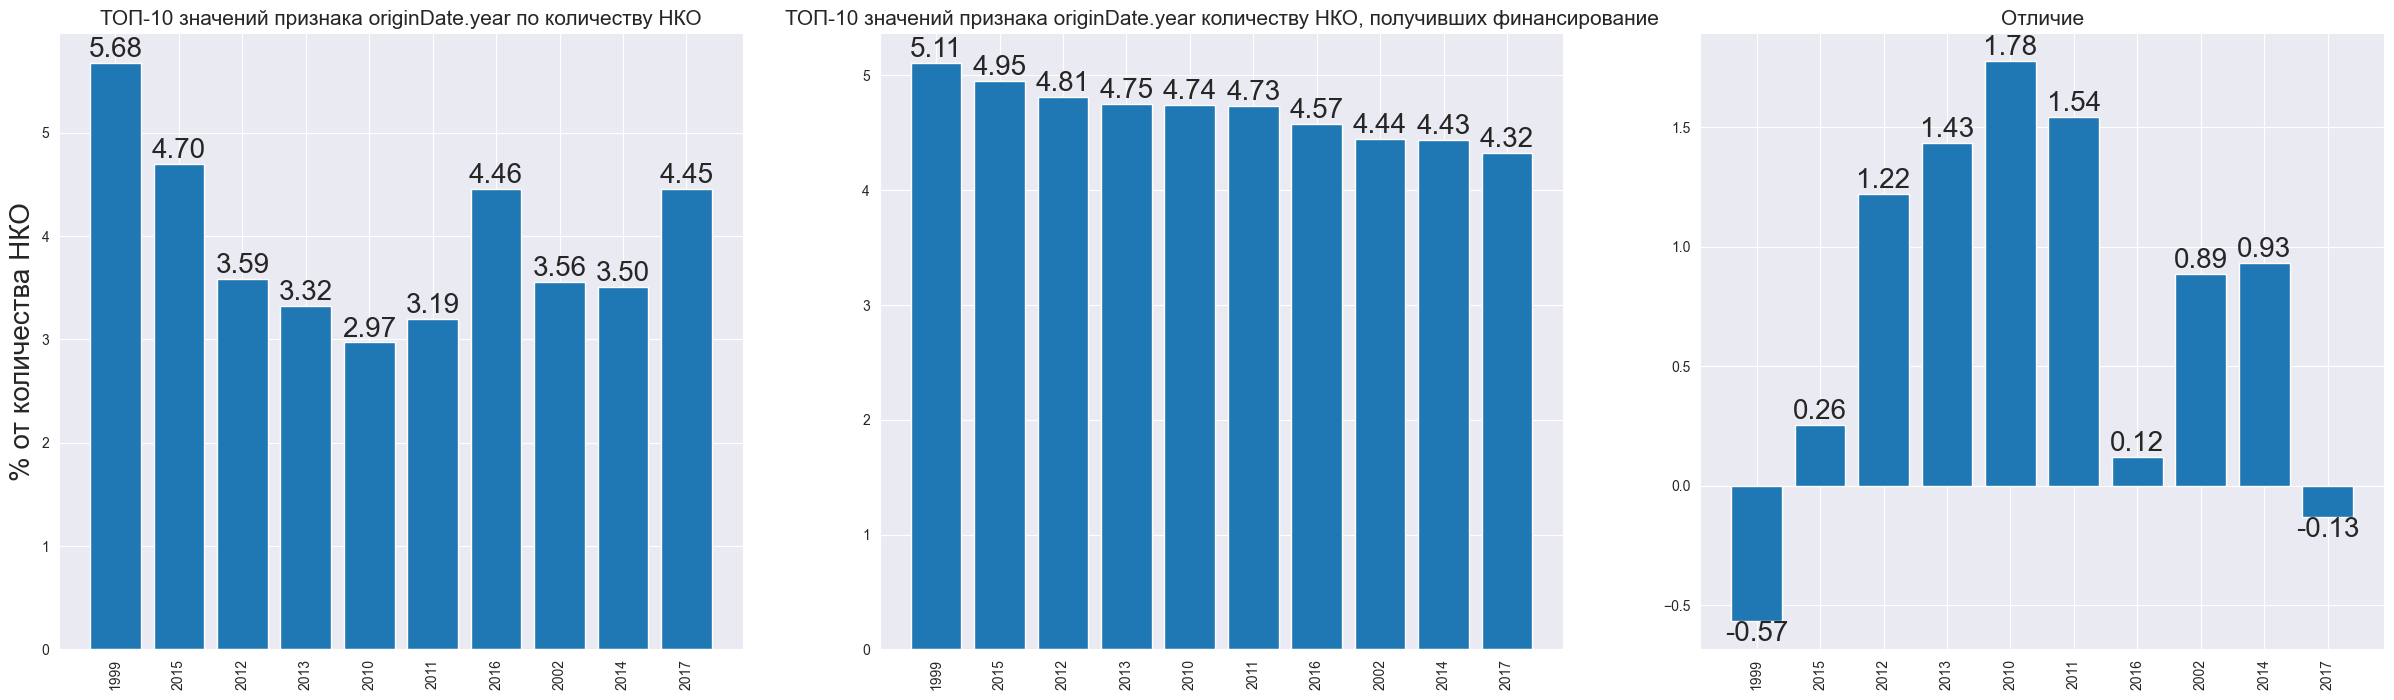

In [6]:
bar_features('originDate.year')

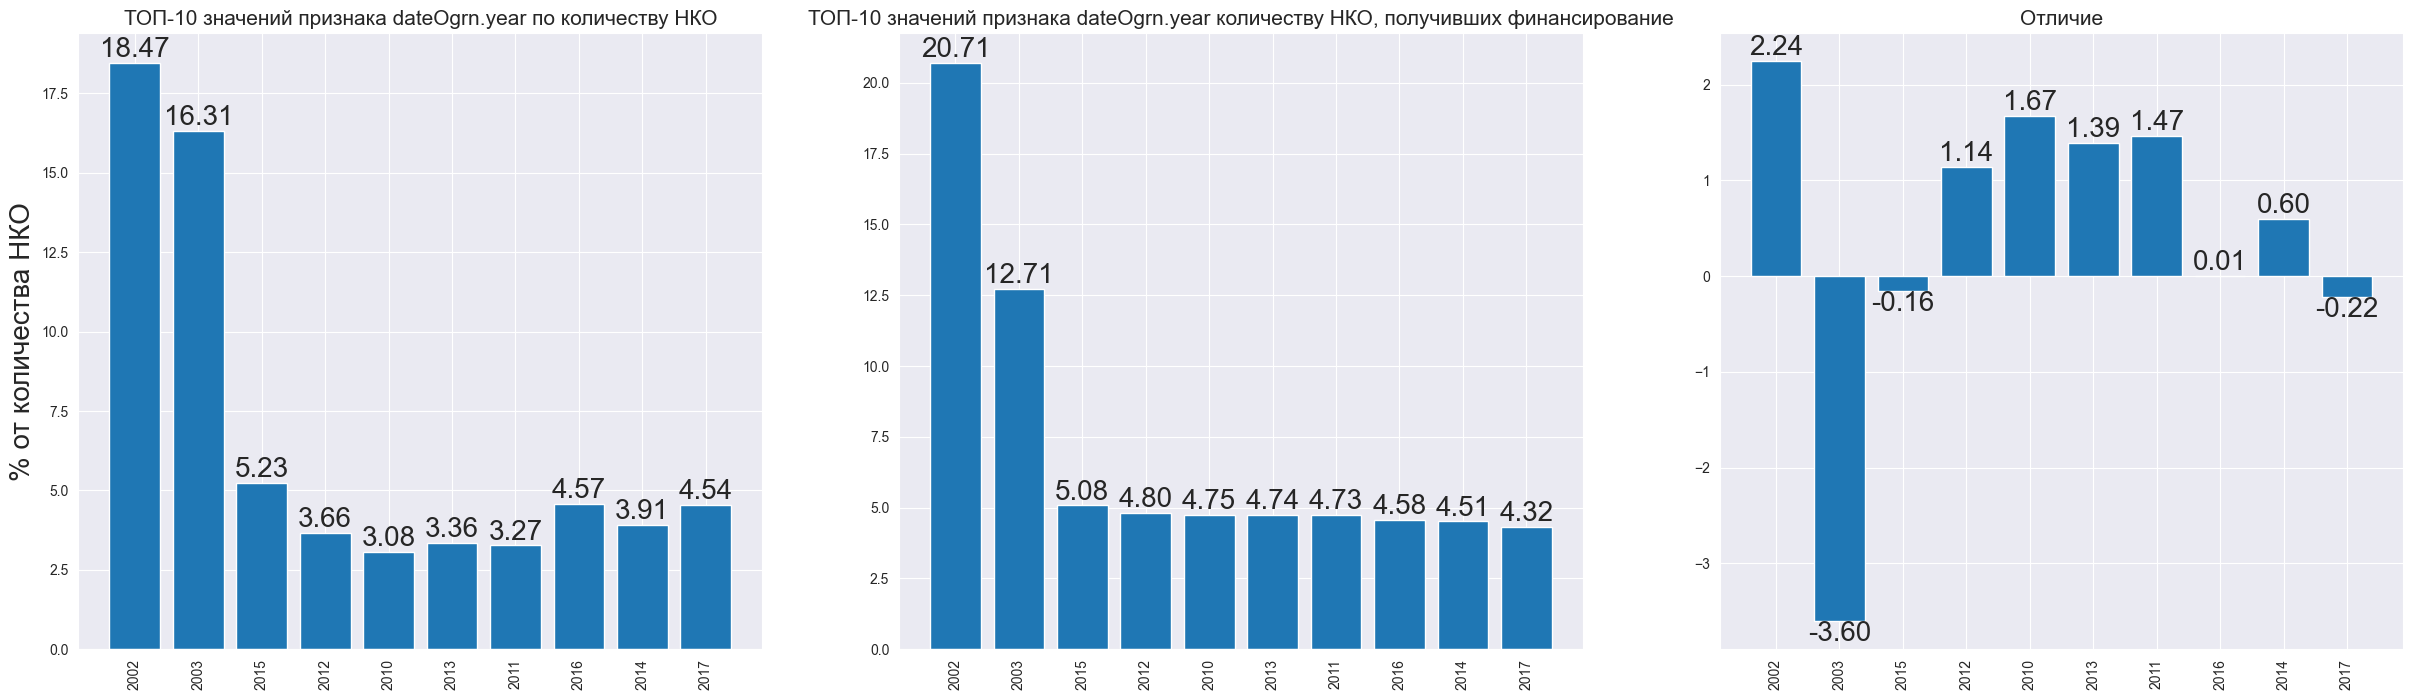

In [7]:
# заодно проверим признак в годом выдачи ЕГРН
bar_features('dateOgrn.year')

# В целом по основным годам (2002, 2010-2014) - он повторяет результаты признака 'originDate.year'

#### Вывод:
На основе представленных данных можно сделать вывод, что есть определённая зависимость от года регистрации: так при регистрации в 2002, 2010, 2011, 2012, 2013, 2014 шансы получить финансирование немного выше, а при регистрации в 1999 году - ниже.

### 2.3 Есть зависимость получения финансирования от вида экономической деятельности?

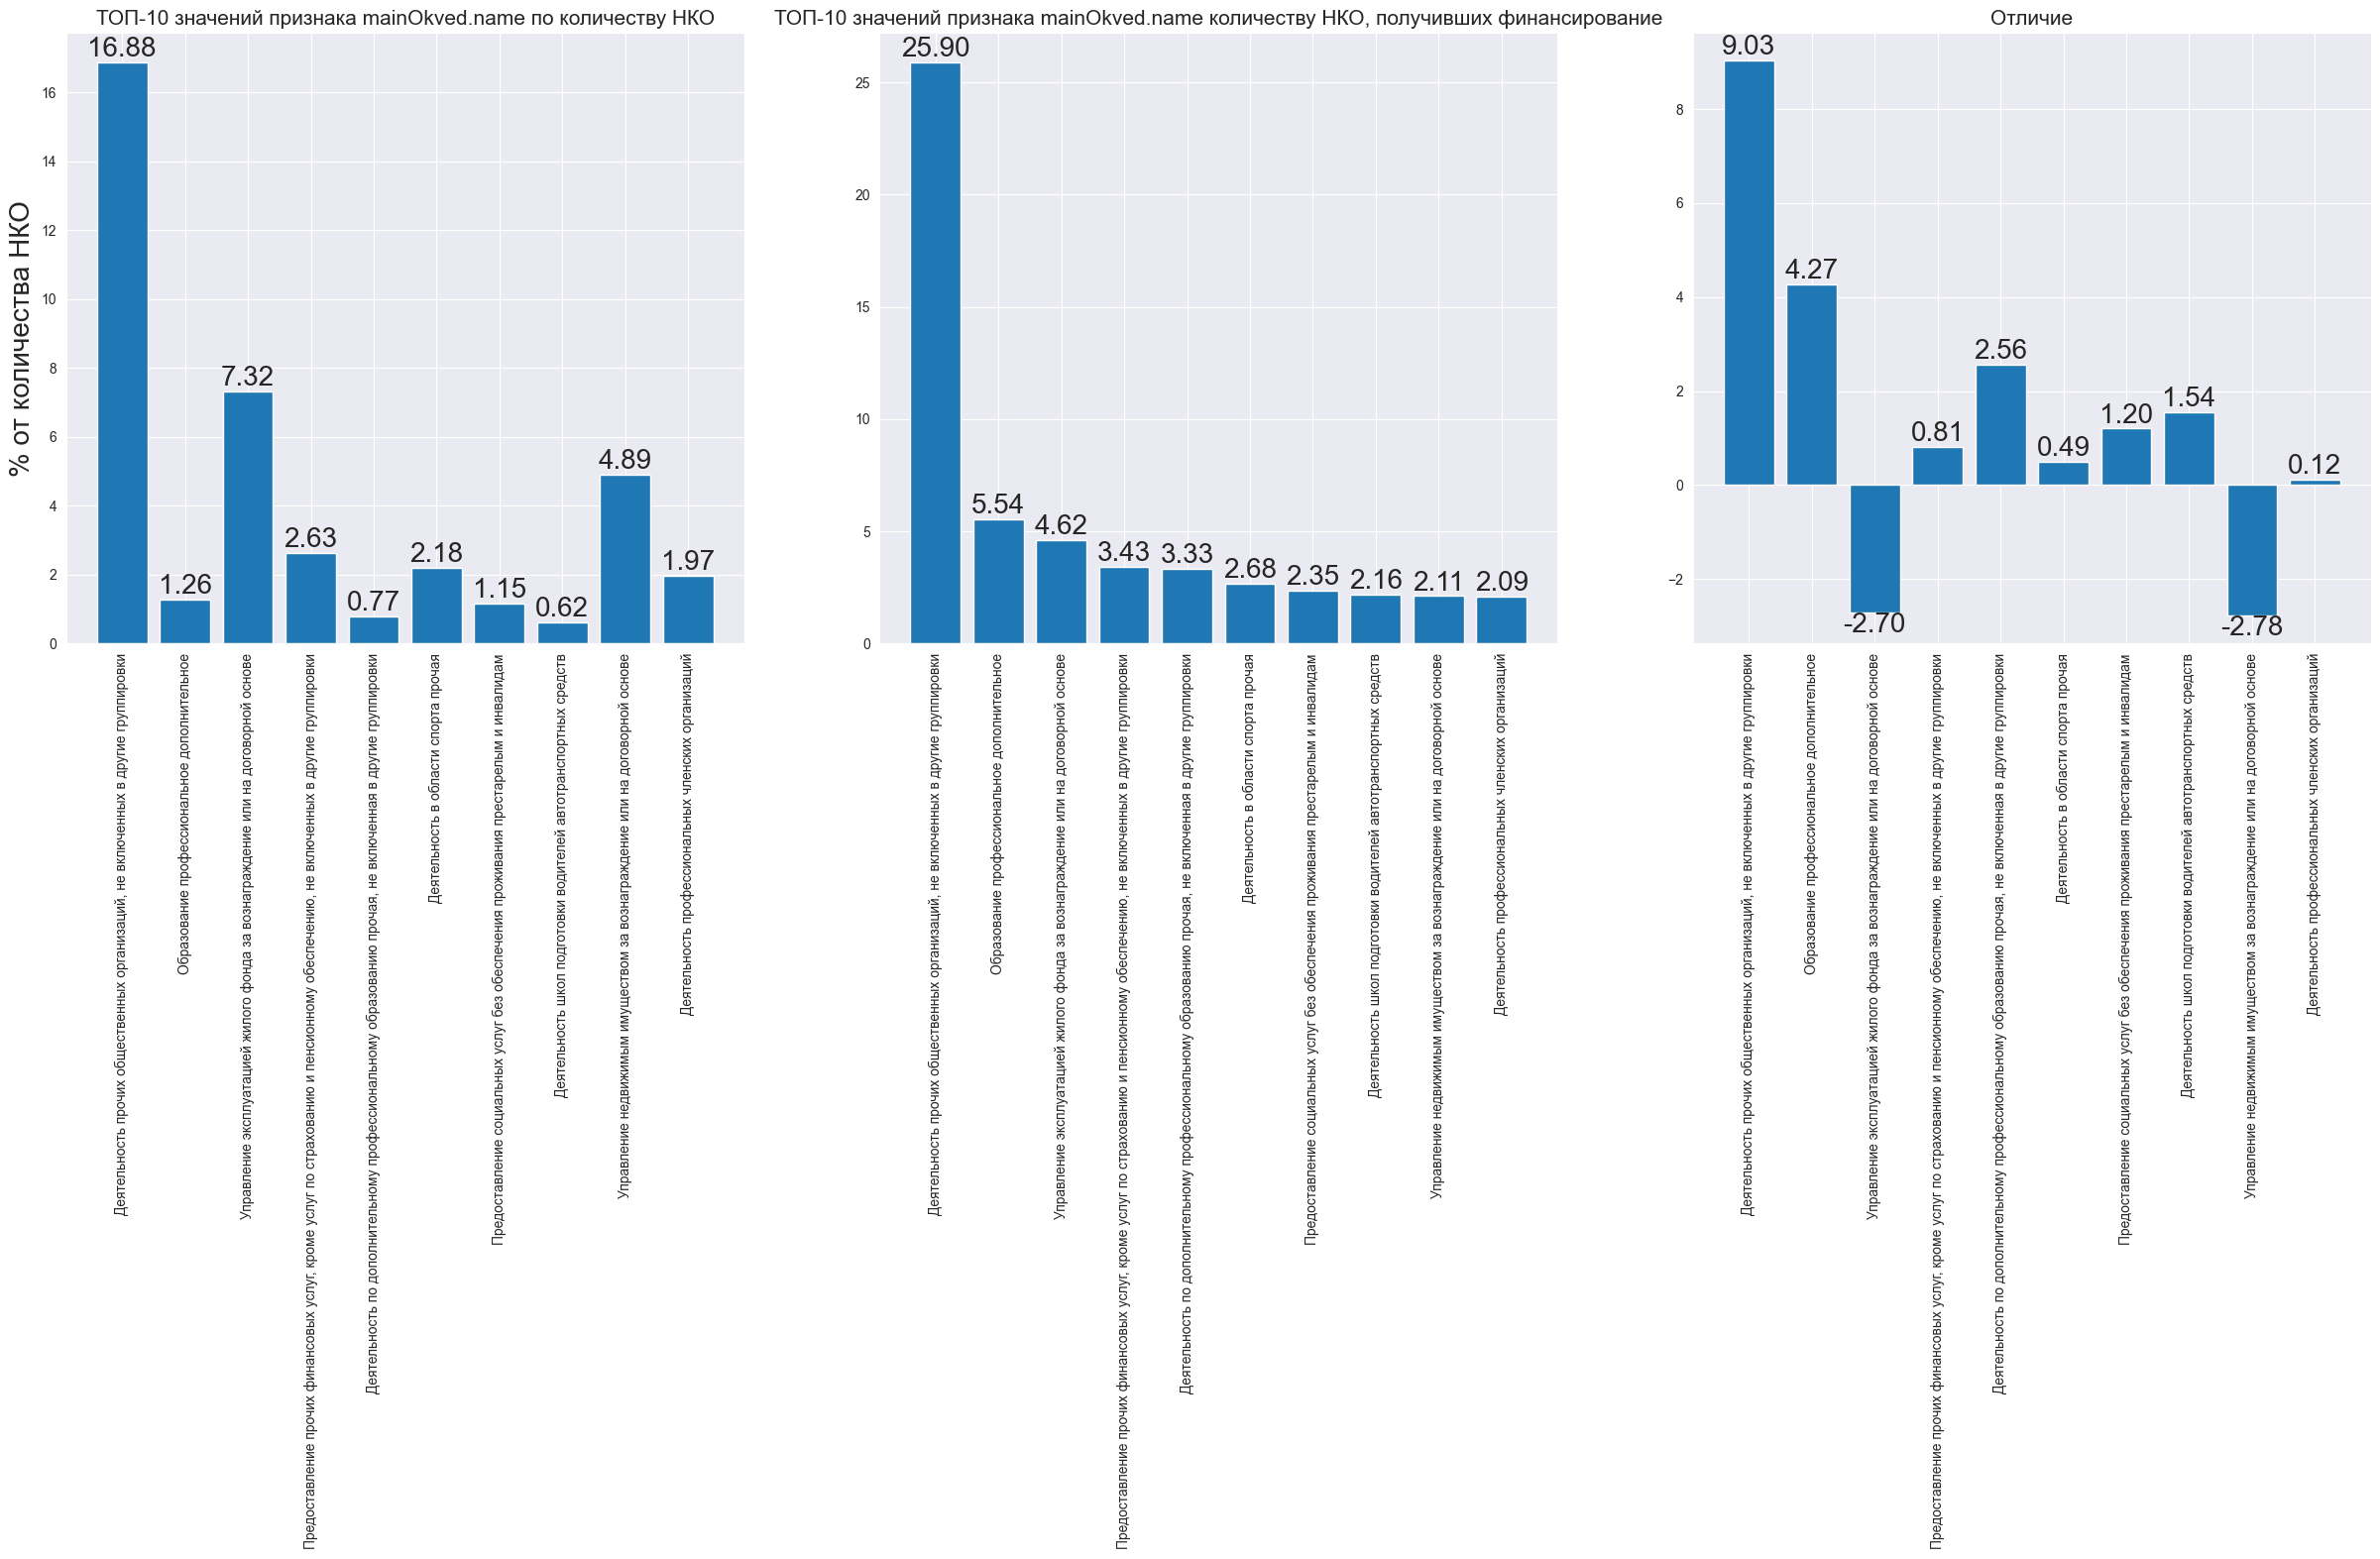

In [8]:
bar_features('mainOkved.name')

#### Вывод:
На основе представленных данных можно сделать вывод, что есть определённая зависимость от года вида деятельности организации.

Так при ОКВЭД:
* Деятельность прочих общественных организаций, не включенных в другие группировки;
* Образование профессиональное дополнительное;
* Деятельность по дополнительному профессиональному образованию прочая, не включённая в другие группировки;
* Деятельность для подготовки водителей автотраснортных средств

шансы на получение финансирования будут выше,

а при ОКВЭД:
* Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе;
* Управление недвижимым имуществом за вознаграждение или на договорной основе

шансы будут ниже.

### 2.4 Проверка гипотез статистическими тестами

Проверим наши гипотезы статистическими тестами.

В первую очередь проверим наличие связей между признаками, а затем уже будем измерять силу этой связи.

Начнём с проверки наличия связи. Т.к. мы сравниваем катеригориальную переменную (регион, вид деятельности и т.д.) с другой категориальной (получение/неполучение финансирования), то используем тест хи-квадрат на независимость величин

Нулевая гипотеза - *cвязь между переменными отсутствует*

Ненулевая гипотеза - *между переменными есть связь*

Уровень значимости поставим `p=0.05`

In [9]:
# напишем функцию для вывода

def test_chi(column):
    
    # приведем данные в нужную форму для проверки
    data0 = pd.DataFrame(df[column].value_counts(normalize=False))
    data0.columns = ['incomeTotal_signal']
    data0[column] = data0.index
    
    data1 = pd.DataFrame(df[df['incomeTotal_signal']==1][column].value_counts(normalize=False))
    data1.columns = ['incomeTotal_signal']
    data1[column] = data1.index
    
    data_result = data0.merge(right=data1, how='left', on=column)
    data_result.sort_values(by=['incomeTotal_signal_y'], ascending=False)
    
    data_result['incomeTotal_signal_x'] = data_result['incomeTotal_signal_x'] - data_result['incomeTotal_signal_y']
    
    # уменьшим количество степеней для теста до 19 и транспонируем
    data_to_test = data_result[['incomeTotal_signal_x','incomeTotal_signal_y']].head(20).T
    
    # тестируем
    chi2, p, dof, expected = chi2_contingency(data_to_test)
    
    if p<0.05:
        return f'связь есть'
    else: 
        return f'связи нет'

In [10]:
#пройдем по всем столбцам кроме сигнального для поиска наличия связей
column_list = list(df.columns)
column_list.remove('incomeTotal_signal')

#создадим df с итоговыми результатам
rel_df = pd.DataFrame(index=column_list, columns=['result'])

for i in column_list:
    rel_df['result'][i] = test_chi(i)

In [11]:
rel_df[rel_df['result']=='связь есть']

# связь есть с 18 признаками

,result
regionName,связь есть
minjustForm,связь есть
minjustStatus,связь есть
kpp,связь есть
hasRegionalSupport,связь есть
statusDetail.shortName,связь есть
opf.name,связь есть
oktmo.name,связь есть
mainOkved.name,связь есть
okato.name,связь есть


In [12]:
# силу связи будем проверять через корреляцию 
# при этом, т.к. в рамках одного признака много значений, то будем рассматривать только корреляцию с силой больше 0.02 (по модулю)
# это позволит нам точнее вычленить закономерности

# напишем функцию

def top_corr(column, df=df):
    
    #вызываем encoder, кодируем
    encoder = ce.OneHotEncoder(cols=[column], use_cat_names=True) 
    data_coded = encoder.fit_transform(df[column])
    data_concat = pd.concat([df[['incomeTotal_signal']], data_coded], axis=1)
    
    
    # считаем таблицу корреляций для каждого признака, убираем лишнее
    corr_table = pd.DataFrame(data_concat.corr()['incomeTotal_signal'].sort_values(ascending=False))
    
    
    # готовим df с большими значениями коэффициентов корреляций и объединяем их
    high_concat = corr_table[(corr_table['incomeTotal_signal']<1)&(corr_table['incomeTotal_signal']>=0.02)]
    low_concat = corr_table[(corr_table['incomeTotal_signal']>-1)&(corr_table['incomeTotal_signal']<=-0.02)]
    all_concat = pd.concat([high_concat, low_concat], axis=0)
    
    # рисуем график
    fig = plt.figure(figsize=(10, 4))
    axes = fig.add_axes([0, 0, 1, 1])
    bar1 = axes.barh(
        y=all_concat.index,
        width = all_concat['incomeTotal_signal'].values
    )
    
    axes.xaxis.set_tick_params(rotation=90)
    axes.bar_label(bar1, fmt='%.3f',fontsize=10)
    axes.set_title(f"ТОП значений корреляций в рамках признака {column} c признаком получения/неполучения финансирования", fontsize=15)
    
    plt.savefig(f'data/images/top_corr_{column}.png', bbox_inches='tight')

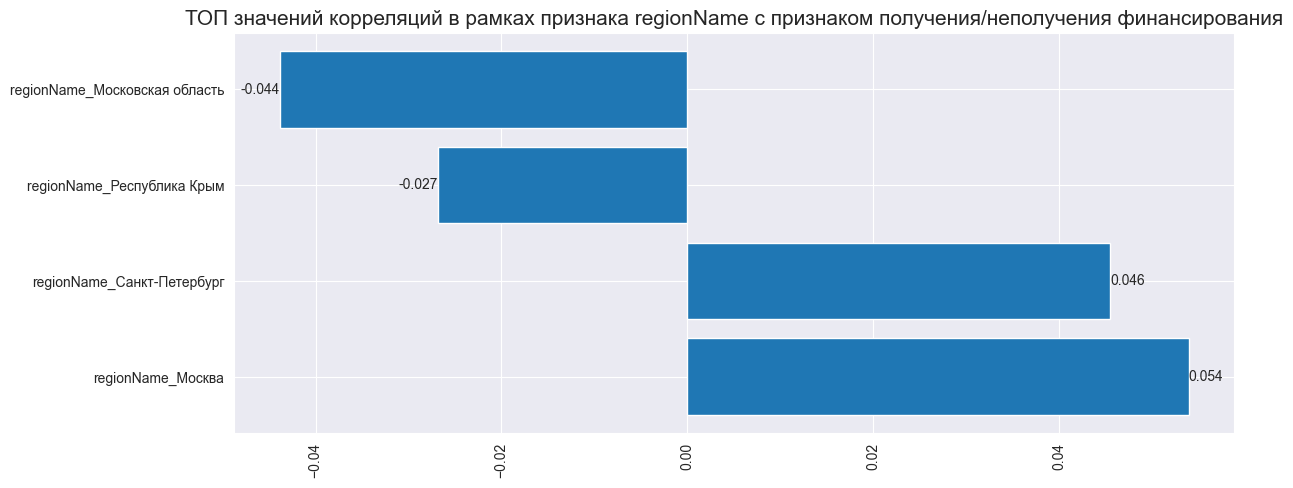

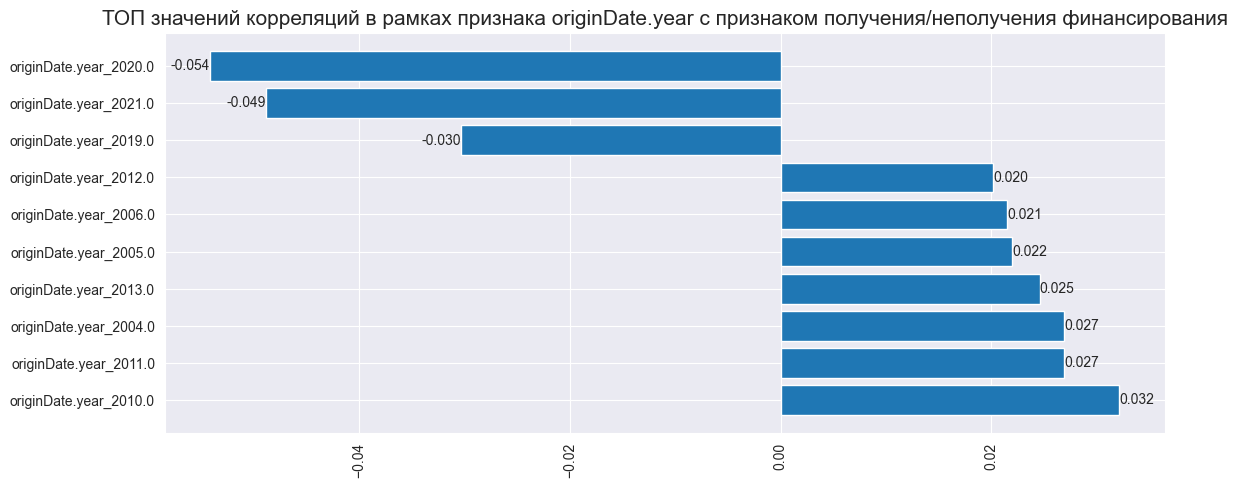

In [13]:
# Посмотрим на признаки, где обнаружена связь
rel_list = ['regionName', 'originDate.year']

for i in rel_list:
    top_corr(column=i)

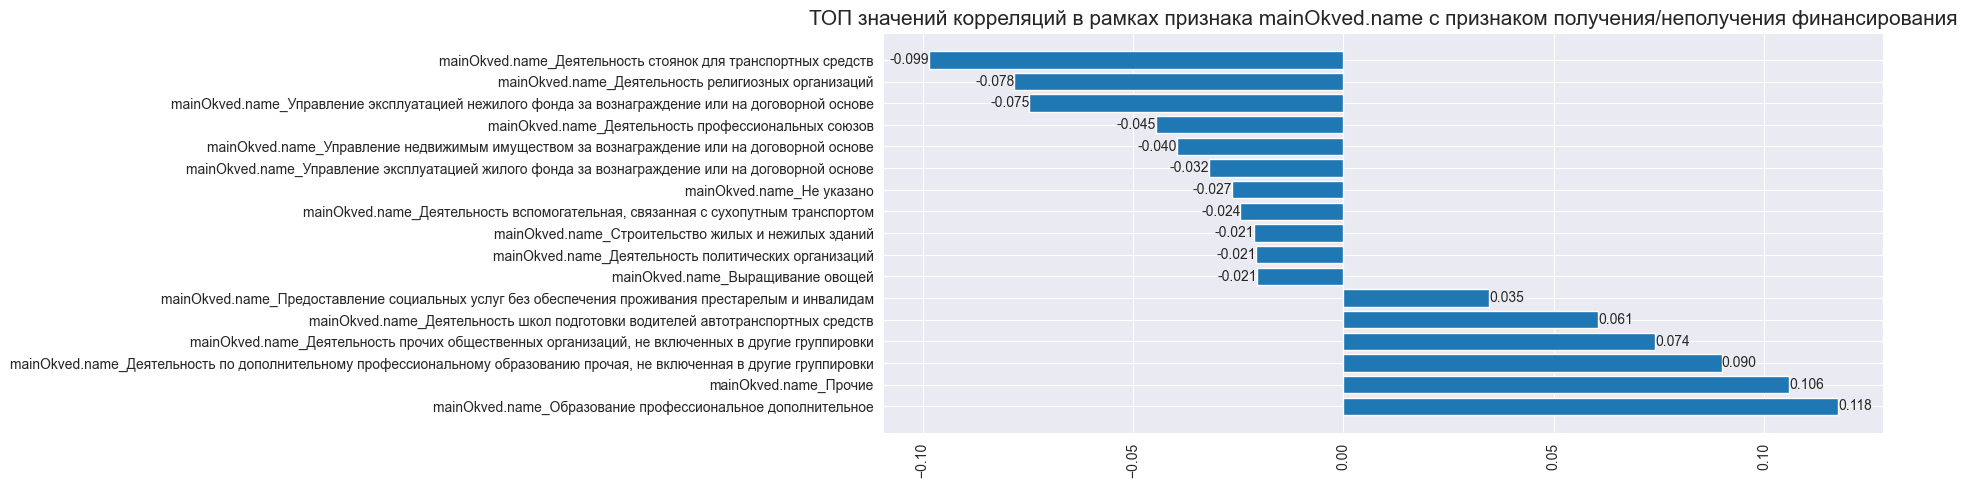

In [14]:
# для признака mainOkved.name будем рассматривать только ТОП-25 самых часто встречающихся явлений (покрывает более 80% НКО), потому что уникальных значений там больше 1000
# cделаем копию df для проверки
df_copy_okved = df.copy()

#список с топ значениями ОКВЭД
top_25_okved = list(df['mainOkved.name'].value_counts(normalize=True).head(25).index)

#меняем
df_copy_okved['mainOkved.name'] = df_copy_okved['mainOkved.name'].apply(lambda x: x if x in top_25_okved else "Прочие")

#cчитаем
top_corr(df=df_copy_okved, column='mainOkved.name')

#### Вывод:
Тесты действительно подтвердили наличие связи, но указанная связь оказалась не слишком высокой. Тем не менее можно выделить следующие зависимости:
* Отмечается положительная корреляция НКО с регистрацией в г. Москва и г. Санкт-Петербург, отрицательная - для НКО с регистрацией в Московской области и Крыму
  
* Отмечается положительная корреляция НКО с датой основания с 2004-2006, 2010-2013 гг., отрицательная - для НКО датой основания с 2004-2006, 2019-2021
  
* Отмечается положительная корреляция для НКО с основным ОКВЭД - Образование профессиональное дополнительное, Деятельность по дополнительному профессиональному образованию прочая, не включенная в другие группировки, Деятельность прочих общественных организаций, не включенных в другие группировки. Отрицательная корреляция - для НКО с основным ОКВЭД, имеющих ОКВЭД - Деятельность стоянок для транспортных средств, Деятельность религиозных организаций, Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе

### 2.5 Проверка других признаков, поиск закономерностей

In [15]:
# Перед тем как проверять признаки, проверим частотность их значений
# Если доля компаний, которая имееn значение из ТОП-n значений будет низкой, то не будем рассматривать признак вообще

# сделаем df c этими значениями

value_counts_df = pd.DataFrame(index=list(rel_df[rel_df['result']=='связь есть'].index), columns=['top-10', 'top-25', 'top-50'])

for i in list(rel_df[rel_df['result']=='связь есть'].index):
    for j in [10, 25, 50]:
        value_counts_df[f'top-{j}'][i] = df[i].value_counts(normalize=True).head(j).sum()

In [16]:
value_counts_df

# убираем из рассматриваемых признаков kpp, oktmo.name, okato.name

,top-10,top-25,top-50
regionName,0.38841,0.628982,0.869457
minjustForm,0.921725,0.997013,1.0
minjustStatus,1.0,1.0,1.0
kpp,0.060109,0.121869,0.202092
hasRegionalSupport,1.0,1.0,1.0
statusDetail.shortName,1.0,1.0,1.0
opf.name,0.751009,0.964495,0.998357
oktmo.name,0.355076,0.456423,0.554868
mainOkved.name,0.663468,0.803272,0.884774
okato.name,0.295126,0.377902,0.457066


In [17]:
value_counts_df[value_counts_df['top-50']>0.8].index

Index(['regionName', 'minjustForm', 'minjustStatus', 'hasRegionalSupport',
       'statusDetail.shortName', 'opf.name', 'mainOkved.name', 'okfs.name',
       'dateOgrn.year', 'originDate.year', 'addOkvedCodesCount',
       'addOkvedCodes1Position', 'addOkvedCodes2Position',
       'addOkvedCodes3Position', 'addOkvedCodes4Position'],
      dtype='object')

In [171]:
# Начинаем рассматривать признаки

# Выполнение кода будет однообразным, поэтому его закомментировал
# При необходимости все графики есть в папке data/images



# for i in list(value_counts_df[value_counts_df['top-50']>0.8].index):
#     # выполняем первую функцию
#     bar_features(i)
    
#     df_copy = df.copy()
#     #список с топ-50
#     top_50 = list(df[i].value_counts(normalize=True).head(50).index)
#     #меняем
#     df_copy[i] = df_copy[i].apply(lambda x: x if x in top_50 else "Прочие")
#     #cчитаем
#     top_corr(df=df_copy, column=i)
    
    
    
# Далее можно переходить к выводам

#### Вывод:
* Положительная корреляция отмечается при:
1. Форме по минюсту - учреждение, АНО, общественная организация 
2. Статусе в минюсте как "Зарегистрирована"
3. Форме собственности - собственность общественных объединений, собственность потребительской кооперации
4. ОПФ - частные учреждения, АНО, общественные организации
5. Первом, втором, третьим, четвертым дополнительным код ОКЭВД, связанном с дополнительным образованием, изучением общественного мнения
6. Количестве дополнительных кодов ОКВЭД в пределах от 2 до 25
7. Наличии региональной поддержки


* Отрицательная корреляция отмечается при:
1. Неуказанной форме минюста
2. Неуказанном статусе в минюсте
3. Отсутствии дополнительного кода ОКВЭД
4. Отсутствии региональной поддержки
5. Неуказанной форме собственности
6. ОПФ - гаражные кооперативы, религиозные организации, товарищества собственников недвижимости
7. Статусе - "ликвидируется"


Таким образом портрет "идеальной" НКО для получения финансирования следующий:
* Регистрация в Москве или Санкт-Петербурге
* Дата создания - 2010-2013 года
* Форма минюста - учреждение
* С зарегистрированным статусом в минюсте
* Форма собственности - собственность общественных объединений
* Основной вид деятельности - образование профессиональное дополнительное
* Дополнительнй вид деятельности - также связанный с образованием
* С признаком получения региональной поддержки
* ОПФ - частные учреждения



Портрет НКО, с минимальными шансами на получение финансирования:
* Регистрация в Московской области или в Крыму
* Дата создания - 2019-2021
* Форма минюста не указана
* С неуказанным статусом в минюсте
* Форма собственности - собственность религиозных организаций или не указана
* Основной вид деятельности - религиозная деятельность, стоянка транспортных средств, управление и эксплуатация недвижимости
* Без дополнительныйх ОКВЭД
* Без ранее полученной региональной поддержки
* ОПФ - гаражный кооператив, религиозная организация
* Со статусом - "ликвидируется"

## 3. Кодирование, отбор признаков

### 3.1 Кодирование + создание новых признаков с учётом выявленных закономерностей

На одной из предыдущих итераций пробовал иcпользовать onehot и binary encoder, но они создают слишком большое количество признаков (110 шт.), которые получаются слабыми. Поэтому этот вариант закомментировал

В дальнешем решил использовать только значения признаков, по которым есть сильная связь и уже их делать бинарными. 

In [18]:
# На одной из предыдущих итераций пробовал иcпользовать onehot и binary encoder, но они создают слишком большое количество признаков, которые получаются слабыми
# поэтому этот вариант закоментировал

# # закодируем наши признаки

# # список признаков
# features_to_code = value_counts_df[value_counts_df['top-50']>0.8].index

# # копируем df, приводим признаки к нужному типу
# df_to_code = df.copy()
# df_to_code = df_to_code[features_to_code]
# df_to_code = df_to_code.astype('str')

# # Далее смотрим, если признак имеет количество уникальных значений до 10 (включительно), то используем onehot кодирование, в противном случае - двоичное кодирование

# # разделим признаки на группы
# one_hot_features = []
# bin_features = []

# for column in df_to_code.columns:
#     if df_to_code[column].nunique()<=10:
#         one_hot_features.append(column)
#     else:
#         bin_features.append(column)

# # закодируем one-hot
# one_hot_encoder = OneHotEncoder()
# data_onehot = one_hot_encoder.fit_transform(df_to_code[one_hot_features]).toarray()
# column_names = one_hot_encoder.get_feature_names_out(one_hot_features)
# data_onehot = pd.DataFrame(data=data_onehot, index = df.index, columns=column_names)

# #объдиним с сигнальным
# data_coded = pd.concat([df[['incomeTotal_signal']], data_onehot], axis=1)
# # используем тип int8, чтобы уменьшить вес
# data_coded = data_coded.astype('int8')

# # закодируем двоичные
# for i in bin_features:
#     bin_encoder = ce.BinaryEncoder(cols=[i]) # указываем столбец для кодирования
#     feat_bin = bin_encoder.fit_transform(df_to_code[i])
#     data_coded = pd.concat([data_coded, feat_bin], axis=1)

In [ ]:
# data_coded.info()
# Получилось 110 признаков

In [18]:
# Будем создавать бинарные признаки для выявленных закономерностей, по которым есть сильная связь
# В первую очередь сделаем копию данных
features_to_rest = list(value_counts_df[value_counts_df['top-50']>0.8].index)
features_to_rest.remove('opf.name')
features_to_rest.remove('okfs.name')
features_to_rest.remove('dateOgrn.year')


df_to_rest = df.copy()
df_to_rest = df_to_rest[features_to_rest]

In [19]:
features_to_rest

['regionName',
 'minjustForm',
 'minjustStatus',
 'hasRegionalSupport',
 'statusDetail.shortName',
 'mainOkved.name',
 'originDate.year',
 'addOkvedCodesCount',
 'addOkvedCodes1Position',
 'addOkvedCodes2Position',
 'addOkvedCodes3Position',
 'addOkvedCodes4Position']

In [20]:
# Напишем функцию для создания бинарного признака с сильной связью
def one_hot_top_features(column, df_top=df):
    
    #список с топ-50 значений признака
    top_50 = list(df_top[column].value_counts(normalize=True).head(50).index)
    #меняем остальные значения
    df_top[column] = df_top[column].apply(lambda x: x if x in top_50 else "Прочие")
    df_top[column] = df_top[column].astype('str')
    
    #вызываем encoder, кодируем
    encoder = ce.OneHotEncoder(cols=[column], use_cat_names=True) 
    data_coded = encoder.fit_transform(df_top[column])
    data_concat = pd.concat([df[['incomeTotal_signal']], data_coded], axis=1)
    
    
    # считаем таблицу корреляций для каждого признака, убираем лишнее
    corr_table = pd.DataFrame(data_concat.corr()['incomeTotal_signal'].sort_values(ascending=False))
    
    
    # готовим df с большими значениями коэффициентов корреляций и объединяем их
    high_concat = corr_table[(corr_table['incomeTotal_signal']<1)&(corr_table['incomeTotal_signal']>=0.04)]
    low_concat = corr_table[(corr_table['incomeTotal_signal']>-1)&(corr_table['incomeTotal_signal']<=-0.04)]
    all_concat = pd.concat([high_concat, low_concat], axis=0)
    
    
    #создаем бинарный признак для значений с сильными связями
    for i in all_concat.index:
        df_top[i] = df_top[column].apply(lambda x: 1 if x==i.split('_')[1] or x is True else 0)

In [21]:
df_to_rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340800 entries, 0 to 340799
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   regionName              340800 non-null  object
 1   minjustForm             340800 non-null  object
 2   minjustStatus           340800 non-null  object
 3   hasRegionalSupport      340800 non-null  bool  
 4   statusDetail.shortName  340800 non-null  object
 5   mainOkved.name          340800 non-null  object
 6   originDate.year         340800 non-null  int64 
 7   addOkvedCodesCount      340800 non-null  int64 
 8   addOkvedCodes1Position  340800 non-null  object
 9   addOkvedCodes2Position  340800 non-null  object
 10  addOkvedCodes3Position  340800 non-null  object
 11  addOkvedCodes4Position  340800 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 28.9+ MB


In [22]:
df_to_rest.nunique()

regionName                  86
minjustForm                 39
minjustStatus                3
hasRegionalSupport           2
statusDetail.shortName       5
mainOkved.name            1039
originDate.year             78
addOkvedCodesCount         220
addOkvedCodes1Position     910
addOkvedCodes2Position    1096
addOkvedCodes3Position    1190
addOkvedCodes4Position    1266
dtype: int64

In [23]:
for i in features_to_rest:
    one_hot_top_features(column=i, df_top=df_to_rest)

In [24]:
df_to_rest = df_to_rest.drop(features_to_rest, axis=1)

In [25]:
df_to_rest

,regionName_Москва,regionName_Санкт-Петербург,regionName_Московская область,minjustForm_Учреждение,minjustForm_Автономная некоммерческая организация,minjustForm_Общественная организация,minjustForm_Общественно-государственное общественное объединение,minjustForm_Некоммерческий фонд,minjustForm_Профессиональный союз,"minjustForm_Садоводческие, огороднические, дачные и иные некоммерческие товарищества",...,addOkvedCodes2Position_85.42,addOkvedCodes2Position_0,addOkvedCodes3Position_Прочие,addOkvedCodes3Position_85.42.9,addOkvedCodes3Position_85.42,addOkvedCodes3Position_85.23,addOkvedCodes3Position_0,addOkvedCodes4Position_Прочие,addOkvedCodes4Position_85.23,addOkvedCodes4Position_0
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340795,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
340796,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
340797,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
340798,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [26]:
df_to_rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340800 entries, 0 to 340799
Data columns (total 54 columns):
 #   Column                                                                                                                                          Non-Null Count   Dtype
---  ------                                                                                                                                          --------------   -----
 0   regionName_Москва                                                                                                                               340800 non-null  int64
 1   regionName_Санкт-Петербург                                                                                                                      340800 non-null  int64
 2   regionName_Московская область                                                                                                                   340800 non-null  int64
 3   minjustForm_Учреждение  

In [27]:
df_coded = pd.concat([df[['incomeTotal_signal']], df_to_rest], axis=1)

In [29]:
# Уменьшаем вес, переводя данные в int8
df_coded = df_coded.astype('int8')

In [28]:
# # Сформированный df сохраняем в архив, чтобы потом к нему обращаться (вместо чтения первоначального архива)

# # временная отметка о начале операции архивирования
# localtime_start = time.time()

# compression_opts = dict(method='zip', archive_name='output_reduced_coded.csv') 
# # Определяем параметры архивирования — метод сжатия, имя файла в архиве

# df_coded.to_csv('data/output_reduced_coded.zip', index=False, compression=compression_opts)
# #В ходе выполнения кода содержимое DataFrame сохранено в файле output_reduced_coded.csv, 
# # файл упакован в архив ooutput_reduced_coded.zip, а архив записан в каталог data.

# print(f'Время выполнения записи в архив - {round(time.time() - localtime_start)} cек')

# # Время выполнения записи в архив - 13 cек

### 3.2 Проверка признаков на корреляцию между собой

In [2]:
df = pd.read_csv('data/output_reduced_coded.zip')
df = df.astype('int8')

In [3]:
# Таблица корреляций получается достаточно большой - 110 признаков, поэтому попробуем вычленить экстремальные значения, заменив единицы нулями
test_corr = df.corr()
for i in test_corr.columns:
    test_corr[i][i] = 0


In [4]:
# Максимальное значение корреляций 
test_corr.max().sort_values(ascending=False)
# 0.8056991807262965

# test_corr.min().sort_values(ascending=True)
# Есть два столбца с полной корреляцией
# hasRegionalSupport_False             -1.000000
# hasRegionalSupport_True              -1.000000

addOkvedCodesCount_0                                                                                                                              1.000000
addOkvedCodes1Position_0                                                                                                                          1.000000
minjustStatus_Не указано                                                                                                                          0.991761
minjustForm_Не указано                                                                                                                            0.991761
mainOkved.name_Деятельность религиозных организаций                                                                                               0.974639
minjustForm_Религиозная организация                                                                                                               0.974639
minjustForm_Профессиональный союз                                     

In [5]:
# Посмотрим на топ-20
test_corr.max().sort_values(ascending=False).head(20)

addOkvedCodesCount_0                                                                                 1.000000
addOkvedCodes1Position_0                                                                             1.000000
minjustStatus_Не указано                                                                             0.991761
minjustForm_Не указано                                                                               0.991761
mainOkved.name_Деятельность религиозных организаций                                                  0.974639
minjustForm_Религиозная организация                                                                  0.974639
minjustForm_Профессиональный союз                                                                    0.935894
mainOkved.name_Деятельность профессиональных союзов                                                  0.935894
addOkvedCodes3Position_0                                                                             0.859768
addOkvedCo

In [6]:
# Убираем лишние
df = df.drop(['addOkvedCodesCount_0', 'minjustStatus_Не указано','mainOkved.name_Деятельность религиозных организаций','mainOkved.name_Деятельность профессиональных союзов','mainOkved.name_Деятельность прочих общественных организаций, не включенных в другие группировки','minjustStatus_Исключена'], axis=1)

In [7]:
test_corr.max().sort_values(ascending=False).head(20)

addOkvedCodesCount_0                                                                                 1.000000
addOkvedCodes1Position_0                                                                             1.000000
minjustStatus_Не указано                                                                             0.991761
minjustForm_Не указано                                                                               0.991761
mainOkved.name_Деятельность религиозных организаций                                                  0.974639
minjustForm_Религиозная организация                                                                  0.974639
minjustForm_Профессиональный союз                                                                    0.935894
mainOkved.name_Деятельность профессиональных союзов                                                  0.935894
addOkvedCodes3Position_0                                                                             0.859768
addOkvedCo

In [8]:
test_corr.min().sort_values(ascending=True).head(20)

hasRegionalSupport_False                                                                            -1.000000
hasRegionalSupport_True                                                                             -1.000000
minjustStatus_Не указано                                                                            -0.802783
minjustStatus_Зарегистрирована                                                                      -0.802783
minjustForm_Не указано                                                                              -0.797653
addOkvedCodes4Position_0                                                                            -0.690155
addOkvedCodes4Position_Прочие                                                                       -0.690155
addOkvedCodes3Position_Прочие                                                                       -0.635818
addOkvedCodes3Position_0                                                                            -0.635818
addOkvedCo

In [9]:
test_corr[test_corr['hasRegionalSupport_False']<-0.99][['hasRegionalSupport_False','hasRegionalSupport_True']]
# Они коррелируют между собой, поэтому один из столбцов уберём

,hasRegionalSupport_False,hasRegionalSupport_True
hasRegionalSupport_True,-1.0,0.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340800 entries, 0 to 340799
Data columns (total 49 columns):
 #   Column                                                                                                                                          Non-Null Count   Dtype
---  ------                                                                                                                                          --------------   -----
 0   incomeTotal_signal                                                                                                                              340800 non-null  int8 
 1   regionName_Москва                                                                                                                               340800 non-null  int8 
 2   regionName_Санкт-Петербург                                                                                                                      340800 non-null  int8 
 3   regionName_Московская об

In [11]:
# Убираем ещё
df = df.drop(['hasRegionalSupport_False','addOkvedCodes1Position_0','addOkvedCodes2Position_0','addOkvedCodes3Position_0','addOkvedCodes4Position_0'], axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340800 entries, 0 to 340799
Data columns (total 44 columns):
 #   Column                                                                                                                                          Non-Null Count   Dtype
---  ------                                                                                                                                          --------------   -----
 0   incomeTotal_signal                                                                                                                              340800 non-null  int8 
 1   regionName_Москва                                                                                                                               340800 non-null  int8 
 2   regionName_Санкт-Петербург                                                                                                                      340800 non-null  int8 
 3   regionName_Московская об

#### Примечание: 
Нормализацию и стандартизацию не проводим, т.к. значения наших признаков либо 0, либо 1.

### 3.3 Отбор признаков

In [13]:
# Разбиваем наши данные
X = df.drop(['incomeTotal_signal'], axis=1)
y = df['incomeTotal_signal']

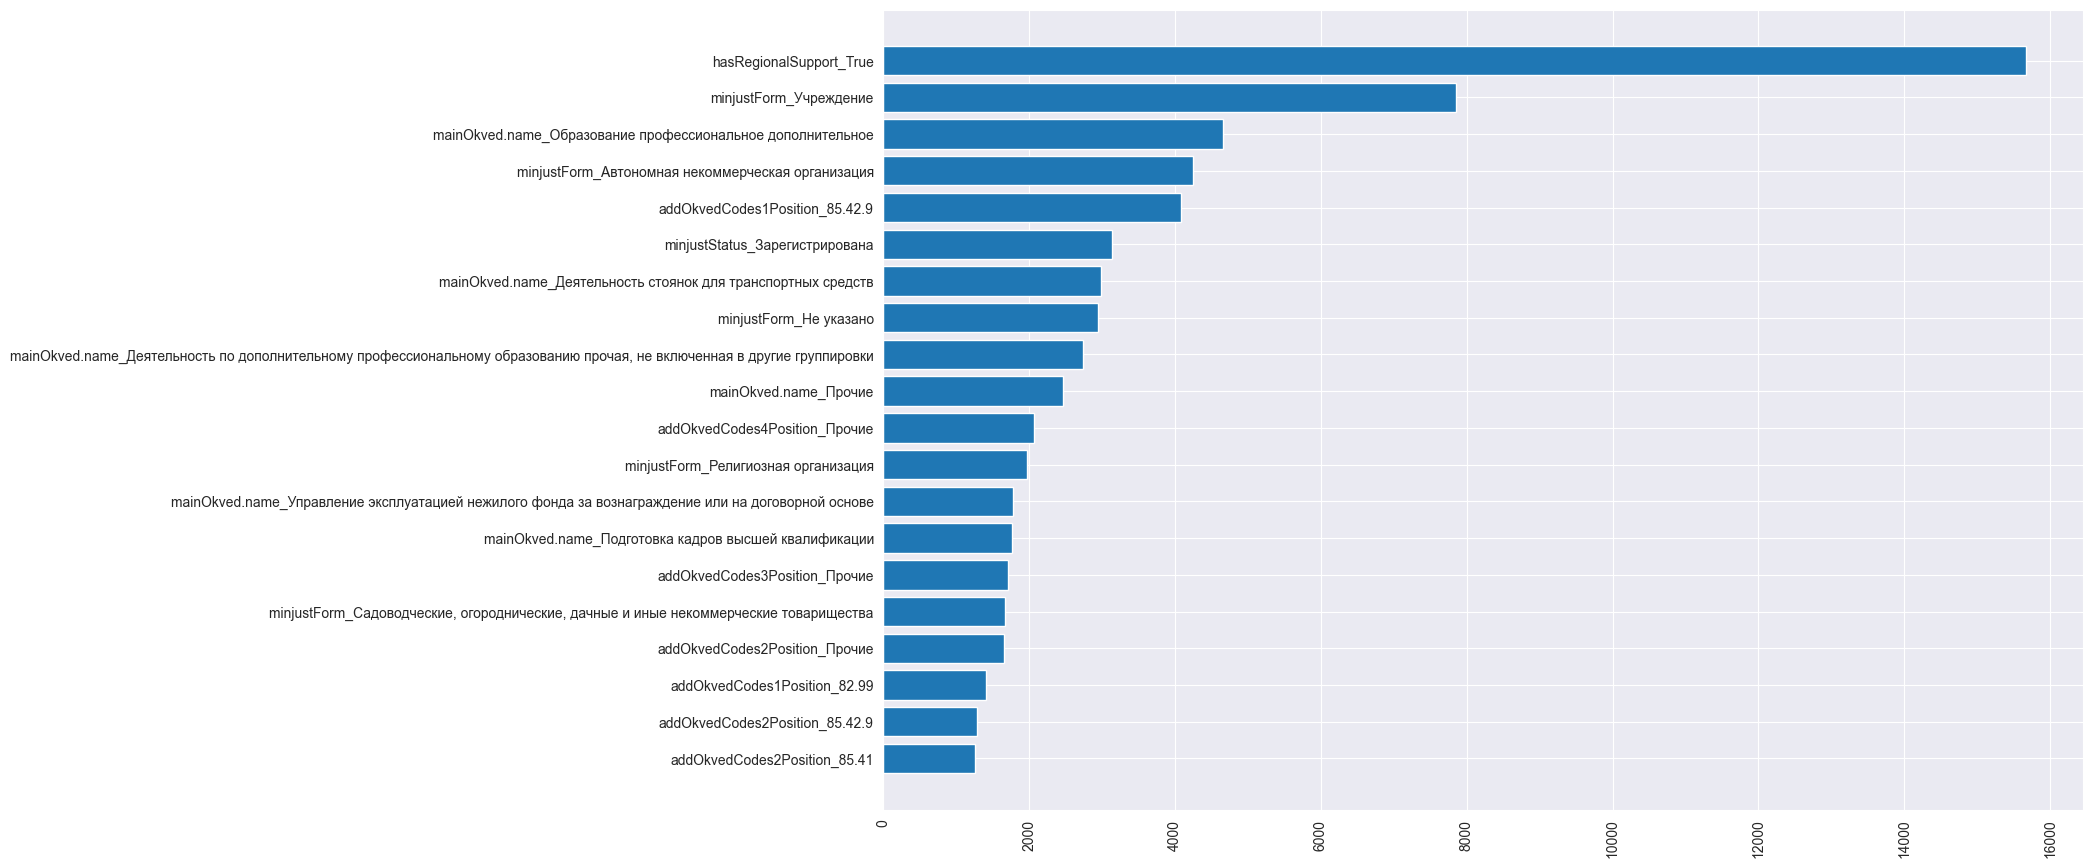

In [14]:
# Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. 
# Метод возвращает массив значений хи-квадрат и p-value для каждого признака. 
# Используем только значения хи-квадрат и выведем их на графике
# ограничимся 20 признаками

imp_cat = pd.Series(chi2(X, y)[0], index=X.columns)
imp_cat = imp_cat.sort_values().tail(20)

fig = plt.figure(figsize=(12, 8))
axes = fig.add_axes([0, 0, 1, 1])
bar1 = axes.barh(
    y=imp_cat.index,
    width = imp_cat.values
    )
axes.xaxis.set_tick_params(rotation=90)


In [15]:
imp_cat

addOkvedCodes2Position_85.41                                                                                                1252.448107
addOkvedCodes2Position_85.42.9                                                                                              1276.801940
addOkvedCodes1Position_82.99                                                                                                1405.151337
addOkvedCodes2Position_Прочие                                                                                               1658.401567
minjustForm_Садоводческие, огороднические, дачные и иные некоммерческие товарищества                                        1664.038429
addOkvedCodes3Position_Прочие                                                                                               1707.522267
mainOkved.name_Подготовка кадров высшей квалификации                                                                        1756.205658
mainOkved.name_Управление эксплуатацией нежилого

In [16]:
# Попробуем проверить ещё через SelectKBest
selector = SelectKBest(chi2, k=20)
selector.fit(X, y)
selector.get_feature_names_out()

array(['minjustForm_Учреждение',
       'minjustForm_Автономная некоммерческая организация',
       'minjustForm_Садоводческие, огороднические, дачные и иные некоммерческие товарищества',
       'minjustForm_Религиозная организация', 'minjustForm_Не указано',
       'minjustStatus_Зарегистрирована', 'hasRegionalSupport_True',
       'mainOkved.name_Образование профессиональное дополнительное',
       'mainOkved.name_Прочие',
       'mainOkved.name_Деятельность по дополнительному профессиональному образованию прочая, не включенная в другие группировки',
       'mainOkved.name_Подготовка кадров высшей квалификации',
       'mainOkved.name_Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе',
       'mainOkved.name_Деятельность стоянок для транспортных средств',
       'addOkvedCodes1Position_85.42.9', 'addOkvedCodes1Position_82.99',
       'addOkvedCodes2Position_Прочие', 'addOkvedCodes2Position_85.42.9',
       'addOkvedCodes2Position_85.41', 'addOkvedCode

In [17]:
# Проверим совпадение признаков
count = 0
for i in list(selector.get_feature_names_out()):
    if i in list(imp_cat.index):
        count += 1
        
count
#20 - методы выдают одинаковые признаки, но в разном порядке

20

In [18]:
X = X[list(selector.get_feature_names_out())]

## 4. Моделирование

Учитывая, что доля НКО, получивших финансирование составляет около 8,6% от общего количества данных то первоначально нашей задачей будет достижение следующих результатов:
* Метрика `recall` для значения 1 - должна быть близко к значению `precision` (так как нам больше важна ошибка второго рода, чем первого)
* По совету ментора метрики `precision` и `recall` должны быть выше 0.65

При построении моделей используем взвешивание классов - `class_weight='balanced'`

### 4.1 Первый проход по всем методам

#### 4.1.1 Логистическая регрессиия

In [19]:
# Напишем функцию для вывода оценки метрик через кросс-валидацию на валидационной выборке

def valid_metrics(model,x=X, y=y):
    
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring=['accuracy','precision','recall'], #метрика
    return_train_score=False, #подсчёт метрики на тренировочных фолдах
    n_jobs=-1
)
    print('Valid k-fold mean accuracy - {:.3f}'.format(np.mean(cv_metrics['test_accuracy'])))
    print('Valid k-fold mean precision - {:.3f}'.format(np.mean(cv_metrics['test_precision'])))
    print('Valid k-fold mean recall - {:.3f}'.format(np.mean(cv_metrics['test_recall'])))

In [69]:
# обучим логистическую регрессию и рассчитаем метрики качества
# log_reg = linear_model.LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')
# valid_metrics(model=log_reg)

# # Valid k-fold mean accuracy - 0.760
# # Valid k-fold mean precision - 0.208
# # Valid k-fold mean recall - 0.635

Valid k-fold mean accuracy - 0.760
Valid k-fold mean precision - 0.208
Valid k-fold mean recall - 0.635


#### 4.1.2 Решающие деревья

In [70]:
# # Пробуем решающие деревья
# dt = tree.DecisionTreeClassifier(
#     criterion='entropy', 
#     random_state=42,
#     class_weight='balanced'
# )

# valid_metrics(model=dt)

# Valid k-fold mean accuracy - 0.761
# Valid k-fold mean precision - 0.210
# Valid k-fold mean recall - 0.640

Valid k-fold mean accuracy - 0.761
Valid k-fold mean precision - 0.210
Valid k-fold mean recall - 0.640


#### 4.1.3 Случайный лес

In [71]:
# # Пробуем случайный лес
# rand_f = RandomForestClassifier(
#     n_estimators = 1000, 
#     criterion = 'gini', 
#     min_samples_leaf = 5, 
#     max_depth = 10, 
#     random_state = 42, 
#     class_weight='balanced'
#     )

# valid_metrics(model=rand_f)

# # Valid k-fold mean accuracy - 0.760
# # Valid k-fold mean precision - 0.210
# # Valid k-fold mean recall - 0.648


Valid k-fold mean accuracy - 0.760
Valid k-fold mean precision - 0.210
Valid k-fold mean recall - 0.648


#### 4.1.4 Градиентный бустинг

In [73]:
# sgd_boost = linear_model.SGDClassifier(
#     max_iter=10000,
#     random_state = 42, 
#     class_weight='balanced'
# )

# valid_metrics(model=sgd_boost)

# # Valid k-fold mean accuracy - 0.769
# # Valid k-fold mean precision - 0.212
# # Valid k-fold mean recall - 0.614


Valid k-fold mean accuracy - 0.769
Valid k-fold mean precision - 0.212
Valid k-fold mean recall - 0.614


#### 4.1.5 Адаптивный бустинг

In [76]:
# adaboost_clf = AdaBoostClassifier(
#     base_estimator=tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced'), 
#     n_estimators=300,
#     learning_rate=0.5
# )

# valid_metrics(model=adaboost_clf)

# # Valid k-fold mean accuracy - 0.763
# # Valid k-fold mean precision - 0.212
# # Valid k-fold mean recall - 0.644

Valid k-fold mean accuracy - 0.763
Valid k-fold mean precision - 0.212
Valid k-fold mean recall - 0.644


#### 4.1.6 Пробуем другие библиотеки (например, CatBoost)

In [23]:
# catbst = CatBoostClassifier(
#     n_estimators=300,
#     learning_rate=0.1,
#     random_state = 42,
#     auto_class_weights='Balanced'
# )

# valid_metrics(model=catbst)

# # Valid k-fold mean accuracy - 0.717
# # Valid k-fold mean precision - 0.192
# # Valid k-fold mean recall - 0.710


Valid k-fold mean accuracy - 0.717
Valid k-fold mean precision - 0.192
Valid k-fold mean recall - 0.710


#### 4.1.7 Стекинг

In [77]:
# # объединим алгоритмы с помощью стекинга 

# # Создаем список кортежей вида: (наименование модели, модель)
# estimators = [
#     ('dt', tree.DecisionTreeClassifier(
#         criterion='entropy',
#         min_samples_leaf=5,
#         max_depth=6,
#         random_state=42,
#         class_weight='balanced'
#         )
#     ),
    
#     ('lr', linear_model.LogisticRegression(
#         random_state=42,
#         max_iter=10000,
#         class_weight='balanced'
#         )
#     ),
    
#     ('ab', AdaBoostClassifier(
#         base_estimator=tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced'), 
#         n_estimators=300,
#         learning_rate=0.5
#         )
#     )
# ]


# # Создаем объект класса стекинг
# stack_cl = StackingClassifier(
#     estimators=estimators,
#     final_estimator=linear_model.LogisticRegression(random_state=42)
# )

# valid_metrics(model=stack_cl)

# # Valid k-fold mean accuracy - 0.914
# # Valid k-fold mean precision - 0.670
# # Valid k-fold mean recall - 0.008

Valid k-fold mean accuracy - 0.914
Valid k-fold mean precision - 0.670
Valid k-fold mean recall - 0.008


##### Вывод:
Методы показывают достаточно хороший `accuracy` (особенно стекинг), но при этом метрики `precision` и `recall` не сбалансированы. Также значения `precision` стабильно низкое, т.е. модель не может уловить зависимость даже при взвешивании классов.

В качестве альтернативы улучшения метрик попробуем добавить бОльше признаков и изменить порог вероятности.

### 4.2 Изменение количества признаков, включаемых в модель

Попробуем посмотреть как влияет количество признаков включаемых в модель на её метрики на валидационной выборке. В качестве модели будем использовать деревья решений, т.к. они быстрее считаются, но при этом не сильно проигрывают в точности (если смотреть предыдущие метрики)

In [76]:
# Формируем отдельную X выборку
test_X = df.drop(['incomeTotal_signal'], axis=1)
test_index = list(range(1, len(test_X.columns)))


# Задаем df, где будут собираться данные
metrics_data = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1'], index = test_index)

# заполняем для каждого шага: выбираем основные признаки, оцениваем метрики через кросс-валидацию, вставляет в нужные поля
for i in test_index:
    test_selector = SelectKBest(chi2, k=i)
    test_selector.fit(test_X, y)
    test_X_i = test_X[list(test_selector.get_feature_names_out())]
    
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = tree.DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42,
        class_weight='balanced'
        )

    cv_metrics = model_selection.cross_validate(
        estimator=model, #модель
        X= test_X_i, #матрица наблюдений X
        y=y, #вектор ответов y
        cv=kf, #кросс-валидатор
        scoring=['accuracy','precision','recall','f1'], #метрика
        return_train_score=False, #подсчёт метрики на тренировочных фолдах
        n_jobs=-1
        )
    
    metrics_data['accuracy'][i] = np.mean(cv_metrics['test_accuracy']).round(3)
    metrics_data['precision'][i] = np.mean(cv_metrics['test_precision']).round(3)
    metrics_data['recall'][i] = np.mean(cv_metrics['test_recall']).round(3)
    metrics_data['f1'][i] = np.mean(cv_metrics['test_f1']).round(3)

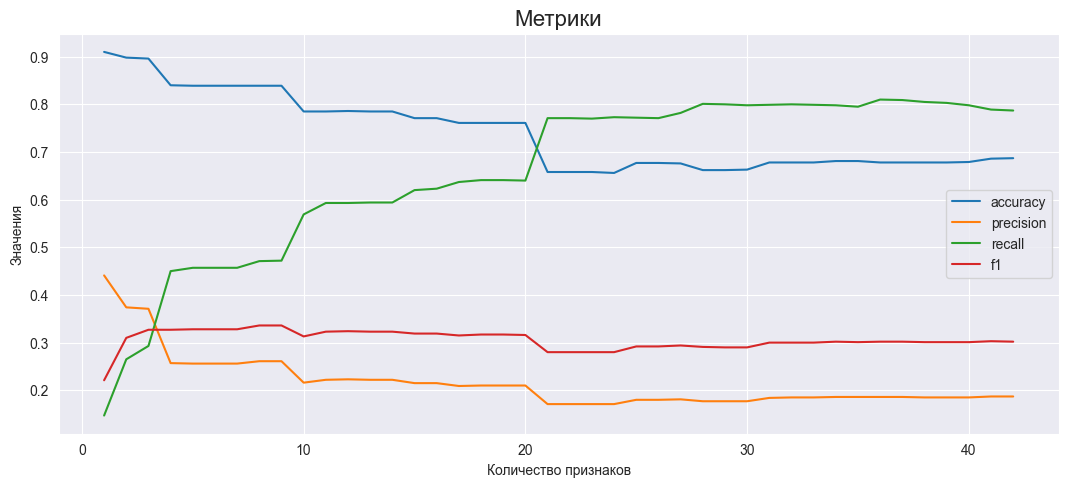

In [77]:
#добавляем график

fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(metrics_data['accuracy'], label='accuracy')
axes.plot(metrics_data['precision'], label='precision')
axes.plot(metrics_data['recall'], label='recall')
axes.plot(metrics_data['f1'], label='f1')     

axes.set_title('Метрики', fontsize=16)
axes.set_xlabel('Количество признаков')
axes.set_ylabel('Значения')
axes.legend();

In [78]:
metrics_data[metrics_data['f1']==metrics_data['f1'].max()]

,accuracy,precision,recall,f1
8,0.839,0.261,0.471,0.336
9,0.839,0.261,0.472,0.336


#### Вывод:
В целом метрики стабилизируются при количестве признаков равном 20, но посмотрим ещё при количестве 8 и 9, т.к. там значение f-1 меры максимально.

### 4.3 Изменение порога вероятности

In [20]:
#Создаём модель
model_tree_20 = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)


# Разбивка на train и test по 20 признакам
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Обучаем модель
model_tree_20.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf1 = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model_tree_20, X_train, y_train, cv=skf1, method='predict_proba')


#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)


Best threshold = 0.19, F1-Score = 0.35


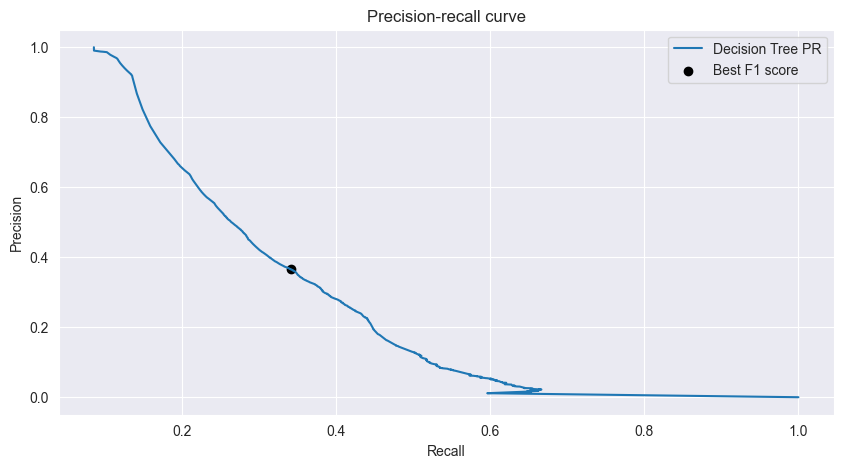

In [21]:
#Далее построим PR-кривую и отметим на ней точку максимума F1-score.
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();


In [22]:
threshold_opt=0.19
y_valid_pred_proba = model_tree_20.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94     62279
           1       0.35      0.37      0.36      5881

    accuracy                           0.89     68160
   macro avg       0.65      0.65      0.65     68160
weighted avg       0.89      0.89      0.89     68160



In [20]:
# Пройдёмся по другим моделями

# обернём операции в функцию

def treshold(model, x=X, y=y):

    # Разбивка на train и test по 20 признакам
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

    #Обучаем модель
    model.fit(X_train, y_train)
    
    #Создаём кросс-валидатор k-fold со стратификацией
    skf1 = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    #Делаем предсказание вероятностей на кросс-валидации
    y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf1, method='predict_proba')


    #Выделяем столбец с вероятностями для класса 1 
    y_cv_proba_pred = y_cv_proba_pred[:, 1]

    #Вычисляем координаты PR-кривой
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)
    
    
    #Далее построим PR-кривую и отметим на ней точку максимума F1-score.
    #Вычисляем F1-score при различных threshold
    f1_scores = (2 * precision * recall) / (precision + recall)
    
    #Определяем индекс максимума
    idx = np.argmax(f1_scores)
    print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

    
    threshold_opt=thresholds[idx].round(2)
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
    #Считаем метрики
    print(metrics.classification_report(y_valid, y_valid_pred))

In [37]:
# # Начнём со случайного леса
# rand_f = RandomForestClassifier(
#     n_estimators = 300, 
#     criterion = 'gini', 
#     random_state = 42, 
#     max_depth = 30
#     )

# treshold(model=rand_f)

# # Best threshold = 0.18, F1-Score = 0.36
# #               precision    recall  f1-score   support

# #            0       0.94      0.93      0.94     62279
# #            1       0.35      0.38      0.36      5881

# #     accuracy                           0.88     68160
# #    macro avg       0.64      0.66      0.65     68160
# # weighted avg       0.89      0.88      0.89     68160


In [38]:
# log_reg = linear_model.LogisticRegression(random_state=42, max_iter=10000)

# treshold(model=log_reg)

# # Best threshold = 0.15, F1-Score = 0.34
# #               precision    recall  f1-score   support

# #            0       0.94      0.90      0.92     62279
# #            1       0.29      0.43      0.35      5881

# #     accuracy                           0.86     68160
# #    macro avg       0.62      0.67      0.63     68160
# # weighted avg       0.89      0.86      0.87     68160

In [39]:
# sgd_boost = linear_model.SGDClassifier(
#     max_iter=10000,
#     random_state = 42,
#     loss='log_loss'
# )

# treshold(model=sgd_boost)

# # Best threshold = 0.13, F1-Score = 0.34
# #               precision    recall  f1-score   support

# #            0       0.95      0.84      0.89     62279
# #            1       0.24      0.52      0.33      5881

# #     accuracy                           0.81     68160
# #    macro avg       0.59      0.68      0.61     68160
# # weighted avg       0.89      0.81      0.84     68160

In [40]:
# adaboost_clf = AdaBoostClassifier(
#     base_estimator=tree.DecisionTreeClassifier(max_depth=3), 
#     n_estimators=300,
#     learning_rate=0.5
# )

# treshold(model=adaboost_clf)

# # Best threshold = 0.75, F1-Score = nan

# #         precision    recall  f1-score   support

# #            0       0.91      1.00      0.95     62279
# #            1       0.00      0.00      0.00      5881

# #     accuracy                           0.91     68160
# #    macro avg       0.46      0.50      0.48     68160
# # weighted avg       0.83      0.91      0.87     68160

In [41]:
# catbst = CatBoostClassifier(
#     n_estimators=300,
#     learning_rate=0.1,
#     random_state = 42
# )

# treshold(model=catbst)

# # Best threshold = 0.19, F1-Score = 0.36
# #               precision    recall  f1-score   support

# #            0       0.94      0.93      0.94     62279
# #            1       0.35      0.39      0.37      5881

# #     accuracy                           0.89     68160
# #    macro avg       0.65      0.66      0.65     68160
# # weighted avg       0.89      0.89      0.89     68160

In [42]:
# estimators = [
#     ('dt', tree.DecisionTreeClassifier(
#         criterion='entropy',
#         min_samples_leaf=5,
#         max_depth=6,
#         random_state=42
#         )
#     ),
    
#     ('lr', linear_model.LogisticRegression(
#         random_state=42,
#         max_iter=10000
#         )
#     ),
    
#     ('ab', AdaBoostClassifier(
#         base_estimator=tree.DecisionTreeClassifier(max_depth=3), 
#         n_estimators=300,
#         learning_rate=0.5
#         )
#     )
# ]


# # Создаем объект класса стекинг
# stack_cl = StackingClassifier(
#     estimators=estimators,
#     final_estimator=linear_model.LogisticRegression(random_state=42)
# )

# treshold(model=stack_cl)


# # Best threshold = 0.12, F1-Score = 0.35
# #               precision    recall  f1-score   support

# #            0       0.94      0.93      0.93     62279
# #            1       0.34      0.39      0.36      5881

# #     accuracy                           0.88     68160
# #    macro avg       0.64      0.66      0.65     68160
# # weighted avg       0.89      0.88      0.88     68160

#### Вывод:
Изменение порога на деревьях решений дало сбалансированные результаты по метрикам при 20 признаках и неплохую точность. В других моделях результаты немного хуже, менее сбалансированы, а сами модели считаются дольше.

Посмотрим сможем ли мы получить хорошие результаты при уменьшении признаков

In [24]:
#Создаём модель
model_tree_8 = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)


# Отбираем 8 признаков
test_selector1 = SelectKBest(chi2, k=8)
test_X1 = df.drop(['incomeTotal_signal'], axis=1)
test_selector1.fit(test_X1, y)
test_X1 = test_X1[list(test_selector1.get_feature_names_out())]


treshold(model=model_tree_8, x=test_X1)

Best threshold = 0.22, F1-Score = 0.34
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     62279
           1       0.37      0.34      0.35      5881

    accuracy                           0.89     68160
   macro avg       0.66      0.64      0.65     68160
weighted avg       0.89      0.89      0.89     68160



In [21]:
#Создаём модель
model_tree_9 = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)


# Отбираем 8 признаков
test_selector2 = SelectKBest(chi2, k=9)
test_X2 = df.drop(['incomeTotal_signal'], axis=1)
test_selector2.fit(test_X2, y)
test_X2 = test_X2[list(test_selector2.get_feature_names_out())]


treshold(model=model_tree_9, x=test_X2)

Best threshold = 0.22, F1-Score = 0.35
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     62279
           1       0.37      0.35      0.36      5881

    accuracy                           0.89     68160
   macro avg       0.65      0.65      0.65     68160
weighted avg       0.89      0.89      0.89     68160



#### Вывод:
При уменьшении признаков с 20 до 8-9 показатели на валидационной выборке почти не меняются. С учётом этого в дальнейшем будем использовать 9 признаков. 

### 4.4 Сэмплирование

В качестве альтернативы улучшения показателей при дисбалансе попробуем использовать пересэмплирование. Используем алгоритм `SMOTE (Synthetic Minority Oversampling Techniques)`.

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

In [31]:
# #инициализируем
# sm = SMOTE(random_state=42)

# # разбиваем и заполняем
# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

# model = tree.DecisionTreeClassifier(
#     criterion='entropy', #критерий информативности
#     random_state=42 #генератор случайных чисел
# )

# #Обучаем модель на тренировочной выборке (с сэмплированием)
# model.fit(X_train_s, y_train_s)
# #Делаем предсказание для каждой из выборок
# y_train_pred = model.predict(X_train)
# y_valid_pred = model.predict(X_valid)
# #Выводим значения метрик    
# print(metrics.classification_report(y_valid, y_valid_pred))


# #          precision    recall  f1-score   support

# #            0       0.96      0.77      0.86     62279
# #            1       0.21      0.63      0.32      5881

# #     accuracy                           0.76     68160
# #    macro avg       0.58      0.70      0.59     68160
# # weighted avg       0.89      0.76      0.81     68160



              precision    recall  f1-score   support

           0       0.96      0.77      0.86     62279
           1       0.21      0.63      0.32      5881

    accuracy                           0.76     68160
   macro avg       0.58      0.70      0.59     68160
weighted avg       0.89      0.76      0.81     68160



#### Вывод:
Пересэмплирование показало себя хуже по метрикам. Использовать его в дальнейшем не будем

### 4.5 Оптимизация гиперпараметров

Попробуем немного оптимизировать гиперпараметры у деревьев решений через Optuna

In [27]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
  max_depth = trial.suggest_int('max_depth', 2, 9, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = tree.DecisionTreeClassifier(
    criterion=criterion, 
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42
    )
  
  test_selector2 = SelectKBest(chi2, k=9)
  test_X2 = df.drop(['incomeTotal_signal'], axis=1)
  test_selector2.fit(test_X2, y)
  test_X2 = test_X2[list(test_selector2.get_feature_names_out())]
  
  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(test_X2, y, stratify=y, test_size=0.2, random_state=42)

  # обучаем модель
  model.fit(X_train, y_train)
  
  # учитываем порог
  threshold_opt=0.22
  y_train_pred_proba = model.predict_proba(X_train)[:, 1]
  y_train_pred = (y_train_pred_proba > threshold_opt).astype('int')
  
  score = metrics.f1_score(y_train, y_train_pred)

  return score

In [28]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="DecisionTree_9", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-01-03 11:02:31,074] A new study created in memory with name: DecisionTree_9


CPU times: total: 0 ns
Wall time: 0 ns


[I 2024-01-03 11:02:33,018] Trial 0 finished with value: 0.21935278176311176 and parameters: {'criterion': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.21935278176311176.
[I 2024-01-03 11:02:35,070] Trial 1 finished with value: 0.349405577407522 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.349405577407522.
[I 2024-01-03 11:02:36,967] Trial 2 finished with value: 0.34939226519337013 and parameters: {'criterion': 'log_loss', 'max_depth': 8, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.349405577407522.
[I 2024-01-03 11:02:38,524] Trial 3 finished with value: 0.3225236412264782 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.349405577407522.
[I 2024-01-03 11:02:39,856] Trial 4 finished with value: 0.21935278176311176 and parameters: {'criterion': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 4}. Best is trial 1 with va

In [30]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3}
# f1_score на обучающем наборе: 0.35

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.35


In [31]:
# рассчитаем точность для валидационной выборки

test_selector2 = SelectKBest(chi2, k=9)
test_X2 = df.drop(['incomeTotal_signal'], axis=1)
test_selector2.fit(test_X2, y)
test_X2 = test_X2[list(test_selector2.get_feature_names_out())]


X_train, X_valid, y_train, y_valid = model_selection.train_test_split(test_X2, y, stratify=y, test_size=0.2, random_state=42)

model = tree.DecisionTreeClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)

threshold_opt=0.22
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')

#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

# Без видимых изменений

# precision    recall  f1-score   support

#            0       0.94      0.94      0.94     62279
#            1       0.37      0.35      0.36      5881

#     accuracy                           0.89     68160
#    macro avg       0.65      0.65      0.65     68160
# weighted avg       0.89      0.89      0.89     68160

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     62279
           1       0.37      0.35      0.36      5881

    accuracy                           0.89     68160
   macro avg       0.65      0.65      0.65     68160
weighted avg       0.89      0.89      0.89     68160



In [32]:
# Улучшилось не сильно. Попробуем добавить ещё исследований

%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=50)

CPU times: total: 0 ns
Wall time: 0 ns


[I 2024-01-03 11:03:50,126] Trial 20 finished with value: 0.349405577407522 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.349405577407522.
[I 2024-01-03 11:03:51,842] Trial 21 finished with value: 0.349405577407522 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.349405577407522.
[I 2024-01-03 11:03:53,658] Trial 22 finished with value: 0.349405577407522 and parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.349405577407522.
[I 2024-01-03 11:03:55,233] Trial 23 finished with value: 0.3487990782593282 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.349405577407522.
[I 2024-01-03 11:03:56,743] Trial 24 finished with value: 0.349405577407522 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.34940557

In [33]:
# Значения лучше не стали
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
# Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3}

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3}


In [26]:
# рассчитаем точность для валидационной выборки

test_selector2 = SelectKBest(chi2, k=9)
test_X2 = df.drop(['incomeTotal_signal'], axis=1)
test_selector2.fit(test_X2, y)
test_X2 = test_X2[list(test_selector2.get_feature_names_out())]


X_train, X_valid, y_train, y_valid = model_selection.train_test_split(test_X2, y, stratify=y, test_size=0.2, random_state=42)

model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=3, random_state=42)
model.fit(X_train, y_train)

threshold_opt=0.22
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')

#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     62279
           1       0.37      0.35      0.36      5881

    accuracy                           0.89     68160
   macro avg       0.65      0.65      0.65     68160
weighted avg       0.89      0.89      0.89     68160



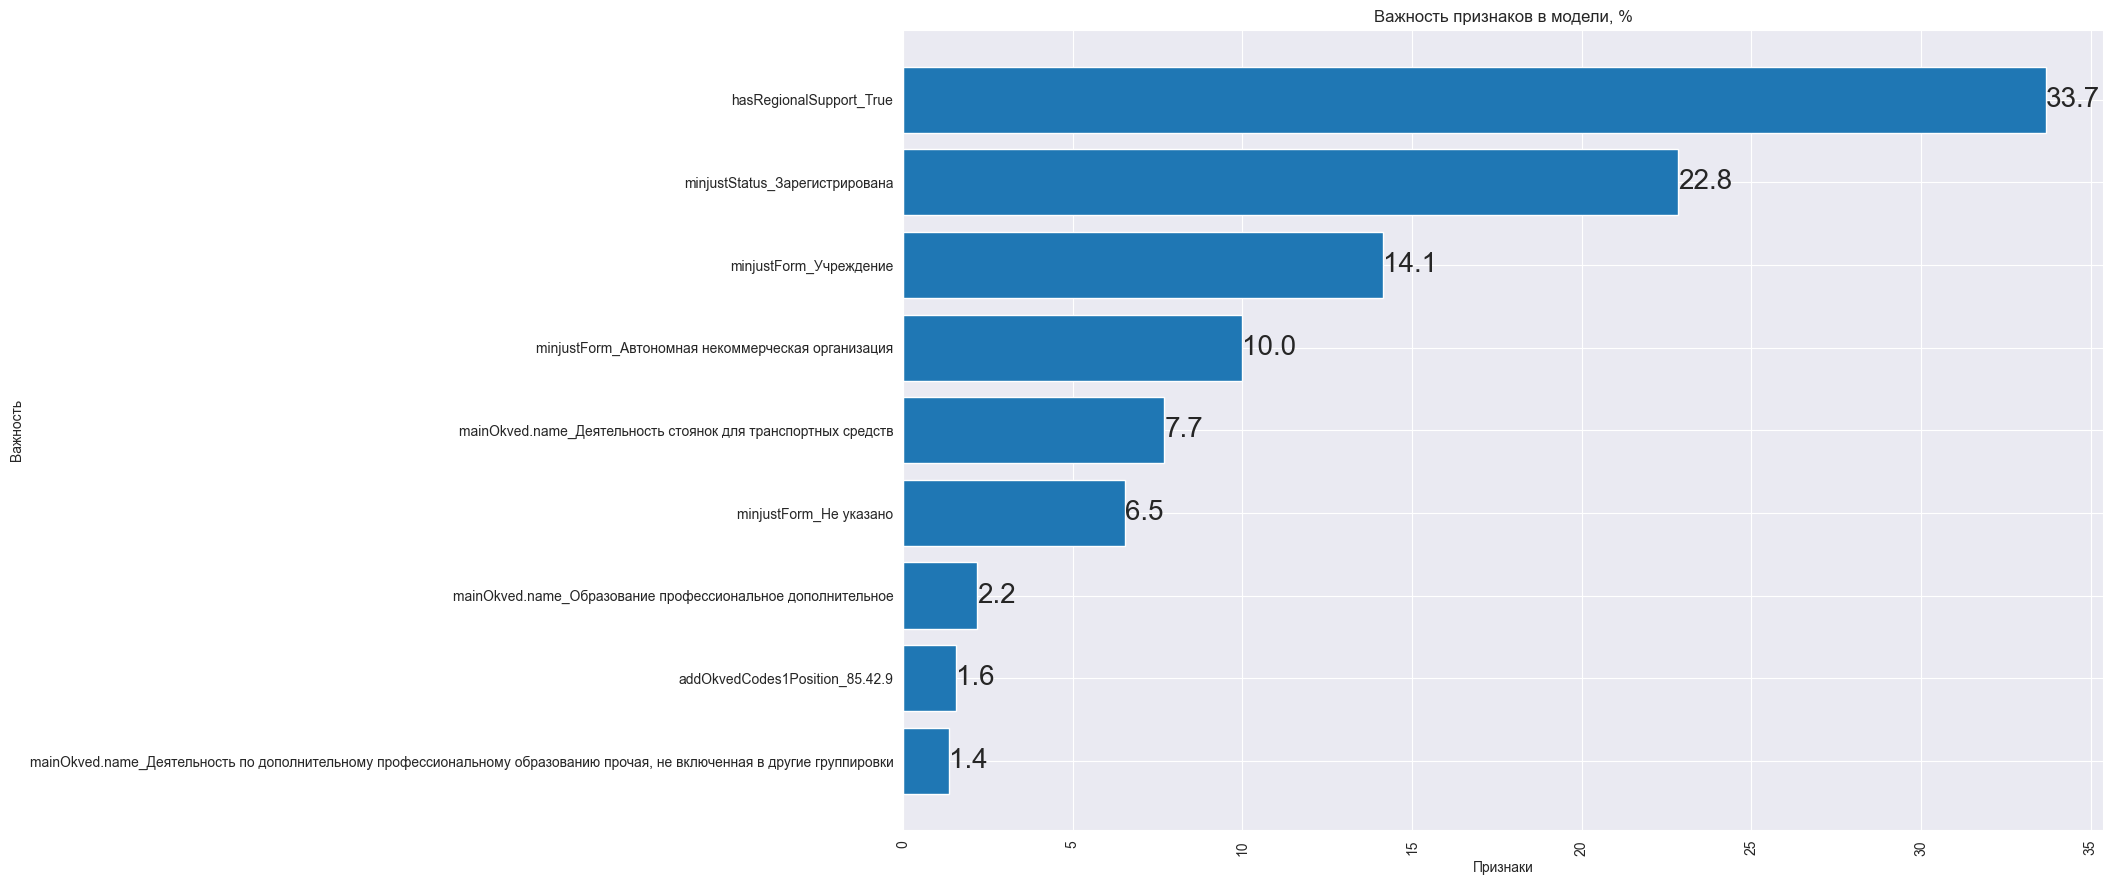

In [27]:
# Посмотрим на важность признаков

imp_cat_tree = pd.Series(model.feature_importances_ * 100, index=X_train.columns)
imp_cat_tree = imp_cat_tree.sort_values()

fig = plt.figure(figsize=(12, 8))
axes = fig.add_axes([0, 0, 1, 1])
bar1 = axes.barh(
    y=imp_cat_tree.index,
    width = imp_cat_tree.values
    )
axes.xaxis.set_tick_params(rotation=90)
axes.bar_label(bar1, fmt='%.1f',fontsize=20)
axes.set_title('Важность признаков в модели, %')
axes.set_xlabel('Признаки')
axes.set_ylabel('Важность');

#### Вывод:
Оптимальным вариантом модели стали деревья решений, построенные на 9 признаках с установленным порогом вероятности в 0.22 (т.е. при превышении указанного порога вероятности НКО будет получать финансирование)

Основными влияющими признаками стали: наличие региональной поддержки (вклад в общую важность признаков - 33.7%), наличие статуса "Зарегистрирована" в минюсте (вклад - 22.8%), форма "Учреждение", указанная в минюсте (вклад - 14.1%), форма "АНО", указанная в минюсте (вклад - 10%)

## 5. Подготовка модели в продакшн

Сделаем сериализацию модели и сделаем `pipeline`

### 5.1 Сериализация модели

In [28]:
# Производим сериализацию и записываем результат в файл формата pkl в папку model_deployment
with open('model_deployment/model.pkl', 'wb') as output:
    pickle.dump(model, output)

In [22]:
# На всякий случай сделаем ещё в формает joblib
# Производим сериализацию и сохраняем результат в файл формата .joblib
joblib.dump(model, 'model.joblib')

['model.joblib']

### 5.2 Подготовка pipeline и его сериализация

Подадим предобработанные данные (X, y), создадим трансформеры, а затем соберём из них `pipeline`

In [23]:
# Создаём pipeline
pipe = Pipeline([  
  ('FeatureSelection', SelectKBest(chi2, k=9)),
  ('DecisionTree_9', model)
  ])

# Обучаем pipeline
pipe.fit(X, y)

Pipeline(steps=[('FeatureSelection',
                 SelectKBest(k=9,
                             score_func=<function chi2 at 0x000001E23153AD30>)),
                ('DecisionTree_9',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        min_samples_leaf=3, random_state=42))])

In [24]:
# Проверяем, что получилось по pipeline

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

threshold_opt=0.22
y_valid_pred_proba = pipe.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')

#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))


#        precision    recall  f1-score   support

#            0       0.94      0.94      0.94     62279
#            1       0.37      0.35      0.36      5881

#     accuracy                           0.89     68160
#    macro avg       0.65      0.65      0.65     68160
# weighted avg       0.89      0.89      0.89     68160

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     62279
           1       0.37      0.35      0.36      5881

    accuracy                           0.89     68160
   macro avg       0.65      0.65      0.65     68160
weighted avg       0.89      0.89      0.89     68160



In [25]:
# Сериализуем pipeline и записываем результат в файл
with open('pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Альтернативный вариант pipeline, когда идёт загрузка с исходной информацией из архива. Представлен в качестве примера, закоментирован, выполняется очень долго из-за большого количества преобразований

In [47]:
# Создадим нужные трансформеры

# class ReadTransformer(TransformerMixin, BaseEstimator):
#     '''Трансформер чтения'''

#     def __init__(self):
#         pass


#     def fit(self, X, y=None):
#         return self


#     def transform(self, X):
#         '''Здесь прописываются действия с данными.'''
#         zip_file = ZipFile(X)

#         # пустой df для объединения      
#         df_output = pd.DataFrame()           
        
#         # читаем архив, читаем построчно json файлы, нормализуем, добавляем в итоговый df  
#         for text_file in zip_file.infolist():
#             if text_file.filename.endswith('.json'):
        
#                 json_data = [json.loads(line) for line in zip_file.open(text_file.filename)]
#                 df_normalized = pd.json_normalize(json_data)
#                 df_output = pd.concat([df_output, df_normalized])
                
#         print('ReadTransformer is done')
            
#         return df_output

In [50]:
# class FeatureTransformer(TransformerMixin, BaseEstimator):
#     '''Трансформер преобразования'''


#     def __init__(self):
#         pass


#     def fit(self, X, y=None):
#         return self


#     def transform(self, X):
#         '''Трансформация данных'''
#         # Убираем недействующие организации
#         data_prepared_11 = X[X['egrulStatus']=='Действует']
        
        
#         # Убираем столбцы с пропусками
#         cols_null_percent = data_prepared_11.isnull().mean() * 100
#         cols_with_null = cols_null_percent[cols_null_percent==100].sort_values(ascending=False)
#         data_prepared_12 = data_prepared_11.drop(list(cols_with_null.index), axis=1)
#         print('data_prepared_12 is done')
        
        
#         # Убираем столбцы contracts
#         # Т.к. классификация у нас будет бинарная, то сделаем сигнальный признак
#         data_prepared_13 = data_prepared_12.copy()
#         data_prepared_13['incomeTotal_signal'] = data_prepared_13['incomeTotal'].apply(lambda x: 1 if x!=0 else 0)
        
        
#         for i in range(2000, 2020):
#             for j in ['sum','count','totalSum', 'totalCount']:
        
#                 if f'incomeDetail.contracts223.{i}.{j}' in data_prepared_13.columns:
#                     contract223 = data_prepared_13[f'incomeDetail.contracts223.{i}.{j}']
#                     data_prepared_13 = data_prepared_13.drop([f'incomeDetail.contracts223.{i}.{j}'], axis=1)
#                 else: contract223 = 0
        
        
#                 if f'incomeDetail.contracts44.{i}.{j}' in data_prepared_13.columns:
#                     contract44 = data_prepared_13[f'incomeDetail.contracts44.{i}.{j}']
#                     data_prepared_13 = data_prepared_13.drop([f'incomeDetail.contracts44.{i}.{j}'], axis=1)
#                 else: contract44 = 0
            
            
#                 if f'incomeDetail.contracts94.{i}.{j}' in data_prepared_13.columns:
#                     contract94 = data_prepared_13[f'incomeDetail.contracts94.{i}.{j}']
#                     data_prepared_13 = data_prepared_13.drop([f'incomeDetail.contracts94.{i}.{j}'], axis=1)
#                 else: contract94 = 0   
            
            
#         data_prepared_13[f'incomeDetail.allcontracts.{i}.{j}'] = contract223 + contract44 + contract94
        
#         # удаляем пустые столбцы, которые получились
#         if data_prepared_13[f'incomeDetail.allcontracts.{i}.{j}'].sum()==0:
#             data_prepared_13 = data_prepared_13.drop([f'incomeDetail.allcontracts.{i}.{j}'], axis=1) 
#         print('data_prepared_13 is done')
        
#         data_prepared_14 = data_prepared_13.copy()
        
#         # Также нас не будут интересовать 100% уникальные значения признаков, например название название учетной записи в vk скорее всего будет уникальным). 

#         #список неинформативных признаков
#         low_information_cols = [] 
        
#         #цикл по всем столбцам
#         for col in data_prepared_14.columns:
#             #наибольшая относительная частота в признаке
#             top_freq = data_prepared_14[col].value_counts(normalize=True).max()
#             #доля уникальных значений от размера признака
#             nunique_ratio = data_prepared_14[col].nunique() / data_prepared_14[col].count()
#             # сравниваем наибольшую частоту с порогом
#             if top_freq > 0.95:
#                 low_information_cols.append(col)
#                 print(f'{col}: {round(top_freq*100, 4)}% одинаковых значений')
#             # сравниваем долю уникальных значений с порогом
#             if nunique_ratio > 0.95:
#                 low_information_cols.append(col)
#                 print(f'{col}: {round(nunique_ratio*100, 4)}% уникальных значений')
        
        
#         # Теперь для того, чтобы принять решение об исключении будем сравнивать значения в столбцах по всему датасету и по выборке организаций, получивших финансирование
#         # Если цифры совпадут, то столбец будем удалять


#         # выборка НКО, где получено финансирование
#         sample = data_prepared_14[X['incomeTotal']!=0]

#         #создаем df для заполнения
#         top_freq_data_columns = pd.DataFrame(columns = ['all_data', 'sample'], index = low_information_cols)


#         # заполняем df расчётными значениями признаков
#         for col in data_prepared_14.columns:
#             top_freq_all_data = data_prepared_14[col].value_counts(normalize=True).max()
#             top_freq_sample = sample[col].value_counts(normalize=True).max()
    
#             if top_freq_all_data > 0.95:
#                 top_freq_data_columns['all_data'][col] = round(top_freq_all_data*100, 4)
#             if top_freq_sample > 0.95:
#                 top_freq_data_columns['sample'][col] = round(top_freq_sample*100, 4)
        
#         #выводим таблицу с признакам, где показатели одинаковые
#         top_freq_data_columns[top_freq_data_columns['all_data']==top_freq_data_columns['sample']]
        
        
#         # удаляем лишние столбцы
#         to_drop_list =  list(top_freq_data_columns[top_freq_data_columns['all_data']==top_freq_data_columns['sample']].index)
#         data_prepared_14 = data_prepared_14.drop(to_drop_list, axis=1)
        
#         # теперь прогоним по уникальным значениям

#         # sample = data_prepared_14[X['incomeTotal']!=0]

#         #создаем df для заполнения
#         nunique_data_columns = pd.DataFrame(columns = ['all_data', 'sample'], index = low_information_cols)


#         # заполняем df расчётными значениями признаков
#         for col in data_prepared_14.columns:
#             nunique_all_data = data_prepared_14[col].nunique() / data_prepared_14[col].count()
#             nunique_sample = sample[col].nunique() / sample[col].count()
    
#             if nunique_all_data > 0.95:
#                 nunique_data_columns['all_data'][col] = round(nunique_all_data*100, 4)
        
#             if nunique_sample > 0.95:
#                 nunique_data_columns['sample'][col] = round(nunique_sample*100, 4)
        
#         #выводим таблицу с признакам, где показатели одинаковые
#         nunique_data_columns[nunique_data_columns['all_data']==nunique_data_columns['sample']]

        
#         # удалим указанные признаки, оставив при этом признак orgn - по нему будем идентифицировать организацию
#         to_drop_list2 = list(nunique_data_columns[nunique_data_columns['all_data']==nunique_data_columns['sample']].index)
#         to_drop_list2.remove('ogrn')
#         data_prepared_14 = data_prepared_14.drop(to_drop_list2, axis=1)
#         print('data_prepared_14 is done')
        
        
#         data_prepared_15 = data_prepared_14.copy()
        
#         # Далее уберем все столбцы IncomeDetail (кроме incomeTotal_signal), т.к. они уже говорят о том, что финансирование было получено и будут давать высокую корреляцию с итоговым признаком
#         # косвенно это будет утечкой данных

#         for i in data_prepared_15.columns:
#             if i.split('.')[0]=='incomeDetail':
#                 data_prepared_15 = data_prepared_15.drop([i], axis=1)
        
#         # Удаляем указанные столбцы
#         to_drop_list3 = [
#             'minjustRegNum','regionCode', 'address', 'fullName', 'administrators', 
#             'successors', 'shortName', 'predecessors', 'reports', 'statusDetail.name', 
#             'statusDetail.code','opf.code', 'opf.version','oktmo.code', 'mainOkved.code',
#             'mainOkved.version','okogu.code','okato.code','okfs.code','incomeTotal']
        
#         data_prepared_15 = data_prepared_15.drop(to_drop_list3, axis=1)
#         print('data_prepared_15 is done')
        
        
#         data_prepared_16 = data_prepared_15.copy()
        
#         # Будем заполнять пропуски по словарю

#         #создаем словарь имя столбца: значение, на на которое надо заменить пропуски
#         # буду ставить на фиксированное значение, т.к. количество значений в каждом признаке велико
#         values = {
#             'regionName': 'Не определено',
#             'minjustForm': 'Не указано',
#             'minjustStatus': 'Не указано',
#             'email': 'Не указано',
#             'kpp':'Не указано',
#             'opf.name': 'Не указано',
#             'oktmo.name': 'Не указано',
#             'mainOkved.name': 'Не указано',
#             'okogu.name': 'Не указано',
#             'okato.name': 'Не указано',
#             'okfs.name':'Не указано'
#         }

#         #заполняем пропуски в соответствии с заявленным словарем
#         data_prepared_16 = data_prepared_16.fillna(values)

#         #данные с пустым признаком kpp удалю - их немного, в данных с отметкой о получении финансирования пустых вообще нет
#         data_prepared_16 = data_prepared_16[data_prepared_16['kpp']!='Не указано']
#         # Количество строк уменьшится на 100 (с 340900 до 340800)
        
        
#         # Пробуем перекодировать даты и вытащить год
#         for i in ['dateOgrn.$date','dateReg.$date','originDate.$date']:
#             data_prepared_16[i] = pd.to_datetime(data_prepared_16[i])
#             data_prepared_16[f'{i.split(".")[0]}.year'] = data_prepared_16[i].dt.year
        
#         #ненужные столбцы удаляем 
#         data_prepared_16 = data_prepared_16.drop(['originDate.$date', 'dateOgrn.$date','dateReg.$date','dateReg.year','check.year'], axis=1)
        
#         # пишем функцию для преобразования оквэд кодов
#         def addokved_codes(value):
#             #проверяем на пустые значения
#             if value=='[]':
#                 return value
    
#             #заменяем кавычки, чтобы json.loads верно прочитал
#             string = value.replace("'",'"')
    
#             #читаем
#             lst = json.loads(string)
    
#             #берём нужны коды и сортируем
#             return list(pd.DataFrame(lst)['code'])
        
#         # Формируем новый признак
#         data_prepared_16['addOkvedCodes'] = data_prepared_16['addOkved'].apply(lambda x: addokved_codes(x))
        
        
#         # сделаем ещё один признак по количеству дополнительных кодов
#         data_prepared_16['addOkvedCodesCount'] = data_prepared_16['addOkvedCodes'].apply(lambda x: 0 if x=='[]' else len(x))
        
        
#         # выводим первые 4 кода в отдельные столбцы
#         for i in list(range(4)):
#             data_prepared_16[f'addOkvedCodes{i+1}Position'] = data_prepared_16['addOkvedCodes'].apply(lambda x: '0' if x=='[]' or len(x)<i+1 else x[i])
            
#         #удаляем два столбца, которые преобразовывали
#         data_prepared_16 = data_prepared_16.drop(['addOkved','addOkvedCodes'], axis=1)   
#         print('data_prepared_16 is done')
        
        
#         # проверка по статистическим тестам

#         def test_chi(column):
#             # приведем данные в нужную форму для проверки
#             data0 = pd.DataFrame(df[column].value_counts(normalize=False))
#             data0.columns = ['incomeTotal_signal']
#             data0[column] = data0.index
            
#             data1 = pd.DataFrame(df[df['incomeTotal_signal']==1][column].value_counts(normalize=False))
#             data1.columns = ['incomeTotal_signal']
#             data1[column] = data1.index
            
#             data_result = data0.merge(right=data1, how='left', on=column)
#             data_result.sort_values(by=['incomeTotal_signal_y'], ascending=False)
            
#             data_result['incomeTotal_signal_x'] = data_result['incomeTotal_signal_x'] - data_result['incomeTotal_signal_y']
            
#             # уменьшим количество степеней для теста до 19 и транспонируем
#             data_to_test = data_result[['incomeTotal_signal_x','incomeTotal_signal_y']].head(20).T
            
#             # тестируем
#             chi2, p, dof, expected = chi2_contingency(data_to_test)
            
#             if p<0.05:
#                 return f'связь есть'
#             else: 
#                 return f'связи нет'
        
        
#         df = data_prepared_16
        
#         #пройдем по всем столбцам кроме сигнального для поиска наличия связей
#         column_list = list(df.columns)
#         column_list.remove('incomeTotal_signal')

#         #создадим df с итоговыми результатам
#         rel_df = pd.DataFrame(index=column_list, columns=['result'])

#         for i in column_list:
#             rel_df['result'][i] = test_chi(i)
        
        
#         # Перед тем как проверять признаки, проверим частотность их значений
#         # Если доля компаний, которая имееn значение из ТОП-n значений будет низкой, то не будем рассматривать признак вообще

#         # сделаем df c этими значениями

#         value_counts_df = pd.DataFrame(index=list(rel_df[rel_df['result']=='связь есть'].index), columns=['top-10', 'top-25', 'top-50'])

#         for i in list(rel_df[rel_df['result']=='связь есть'].index):
#             for j in [10, 25, 50]:
#                 value_counts_df[f'top-{j}'][i] = df[i].value_counts(normalize=True).head(j).sum()
        
    
#         # Будем создавать бинарные признаки для выявленных закономерностей, по которым есть сильная связь
#         # В первую очередь сделаем копию данных
#         features_to_rest = list(value_counts_df[value_counts_df['top-50']>0.8].index)
#         features_to_rest.remove('opf.name')
#         features_to_rest.remove('okfs.name')
#         features_to_rest.remove('dateOgrn.year')

#         df_to_rest = df.copy()
#         df_to_rest = df_to_rest[features_to_rest]
        
        
#         # Напишем функцию для создания бинарного признака с сильной связью
#         def one_hot_top_features(column, df_top=df):
        
#             #список с топ-50 значений признака
#             top_50 = list(df_top[column].value_counts(normalize=True).head(50).index)
#             #меняем остальные значения
#             df_top[column] = df_top[column].apply(lambda x: x if x in top_50 else "Прочие")
#             df_top[column] = df_top[column].astype('str')
            
#             #вызываем encoder, кодируем
#             encoder = ce.OneHotEncoder(cols=[column], use_cat_names=True) 
#             data_coded = encoder.fit_transform(df_top[column])
#             data_concat = pd.concat([df[['incomeTotal_signal']], data_coded], axis=1)
            
            
#             # считаем таблицу корреляций для каждого признака, убираем лишнее
#             corr_table = pd.DataFrame(data_concat.corr()['incomeTotal_signal'].sort_values(ascending=False))
            
            
#             # готовим df с большими значениями коэффициентов корреляций и объединяем их
#             high_concat = corr_table[(corr_table['incomeTotal_signal']<1)&(corr_table['incomeTotal_signal']>=0.04)]
#             low_concat = corr_table[(corr_table['incomeTotal_signal']>-1)&(corr_table['incomeTotal_signal']<=-0.04)]
#             all_concat = pd.concat([high_concat, low_concat], axis=0)
            
            
#             #создаем бинарный признак для значений с сильными связями
#             for i in all_concat.index:
#                 df_top[i] = df_top[column].apply(lambda x: 1 if x==i.split('_')[1] or x is True else 0)
                
#         for i in features_to_rest:
#             one_hot_top_features(column=i, df_top=df_to_rest)
        
        
#         df_to_rest = df_to_rest.drop(features_to_rest, axis=1)
#         print('df_to_rest is done')
        
#         df = df_to_rest
#         df = df.astype('int8')
        
#         # Убираем лишние
#         df = df.drop(['addOkvedCodesCount_0', 
#                       'minjustStatus_Не указано',
#                       'mainOkved.name_Деятельность религиозных организаций',
#                       'mainOkved.name_Деятельность профессиональных союзов',
#                       'mainOkved.name_Деятельность прочих общественных организаций, не включенных в другие группировки','minjustStatus_Исключена'], 
#                      axis=1)
        
#         # Убираем ещё
#         df = df.drop(['hasRegionalSupport_False','addOkvedCodes1Position_0','addOkvedCodes2Position_0','addOkvedCodes3Position_0','addOkvedCodes4Position_0'], axis=1)
        
#         #Убираем столбец с итоговым признаком
#         df = df.drop(['incomeTotal_signal'], axis=1)
        
#         return df

In [26]:
# альтернативный pipeline

# pipe_alt = Pipeline([  
#   ('ReadTransformer', ReadTransformer()),
#   ('FeatureTransformer', FeatureTransformer()),
#   ('FeatureSelection1', SelectKBest(chi2, k=20)),
#   ('FeatureSelection2', SelectKBest(chi2, k=9)),
#   ('DecisionTree_9', model)
#   ])

# X_alt = 'data/data.zip'

# # Обучаем пайплайн
# pipe_alt.fit(X_alt, y)

### 5.3 Подготовка деплоя модели

Деплой модели выполнен с помощью `Flask` таким образом, чтобы пользователь мог ввести 9 признаков, ответив "да" или "нет" на соответствующие вопросы, и по ним получить результат - класс НКО. 

Данные расположены в папке `model_deployment`

#### Вывод:
Сформированы файлы модели и pipeline для вывода в продакшен. Pipeline представлены в двух вариантах: для работы с уже предобработанными данными и с исходными даннымим (второй вариант дан справочно  и закоментирован из-за долгого исполнения всех операций)

### Итоговый вывод:
* Удалось пройти все этапы работы над проектом, начиная от загрузки данных, их преобразования до моделирования и подготовки в продакшен. 
* Результатами работы статили выводы, которые касаются влияния признаков на получения финансирования, а также сформированная модель, предсказывающая класс НКО.
* Несмотря на проделанную работу достигнутые результаты ограничены исходными данными, в которых доля НКО, получивших финансирование относительно невысока, а большинство признаков оказывает слабую связь на результат предсказания.